In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox



In [2]:
df = pd.read_csv(r"C:\Users\AMIT\Downloads\archive (5)\dogecoin_prices_2021.csv")

In [3]:
df.head()

,open_time,price
0,01/01/2021 00:00,0.004672
1,01/01/2021 00:01,0.004673
2,01/01/2021 00:02,0.004686
3,01/01/2021 00:03,0.004671
4,01/01/2021 00:04,0.004676


In [4]:
df.tail()

,open_time,price
523163,30/12/2021 23:56,0.1711
523164,30/12/2021 23:57,0.1712
523165,30/12/2021 23:58,0.1711
523166,30/12/2021 23:59,0.1712
523167,31/12/2021 00:00,0.1710


In [5]:
df.describe()

,price
count,523168.000000
mean,0.204073
std,0.126369
min,0.004607
25%,0.061860
50%,0.218030
75%,0.273200
max,0.737680


In [6]:
from summarytools import dfSummary
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,open_time[object],1. 01/01/2021 00:002. 31/08/2021 19:263. 31/08/2021 19:394. 31/08/2021 19:385. 31/08/2021 19:376. 31/08/2021 19:367. 31/08/2021 19:358. 31/08/2021 19:349. 31/08/2021 19:3310. 31/08/2021 19:3211. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)523,158 (100.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,price[float64],Mean (sd) : 0.2 (0.1)min < med < max:0.0 < 0.2 < 0.7IQR (CV) : 0.2 (1.6),"160,060 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACyUlEQVR4nO3dMW/aQBiA4e9KiA5IDYgq2VgzROqQMUv/QX9s124ZYEZiZWJBFolxBI2LY+jaIUriOzu+D73PfnBSXp3OPhyb4/EoQOi+ND0B4CPOmp5AXYwxHRE59/iI/fF4fK5qPvBzkqEaYzqj0ehnFEVD1894enpKjDG/iDUM74bquTI1tSqdR1E0vLu7e+73+1nZwWma2slkMnx4eDgXEUINwJuh+q5MTa9K/X4/u7y8/OM4vFPpZODlvRXVeWViVUKVPrRH9ViZWJVQCW5PQQVChQqEChUIFSoQKlQI+mTK47AhOhwO7arng+YEG6rPYUOe57Yoipssy+5FxPWGPwISbKjicdiwXC6H8/m8+/Ly0qprcvhcIYcqIm6HDUmScNBwYriYggqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQoXg/wFFU4qiaItIZIxxGc6rfypGqK/Y7XbtPM+/j8fjVqvVKv1WlaZfsnGKCPUV+/3+zFrbvb29za6urpIyY3nJRj0I9Q29Xo+XbASCiymoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKjAL/xrwIOB1SPUivFgYD0ItWI8GFgPQq2J64OBRVFE4r5tEDnRrQOhBsR32yAistlstsaY3yLiMj7YyGsN1fOiIjocDu2KpxQ0n22DiMhqtfo6nU5/jMfjby6he0YuUmPotYXquzrkeW6LorjJsuxeRFyerVfLdduQJEnHNXTfyEXqXc0/FGqaprbstz4+Pl5Ya7vX19dmMBj8LTt+vV7bxWLRTdO0F8fxvszY7XZrRUR2u52N47hb9rt9xjc19v/xLvI8P/P5e202m4vZbOYc+nt3O/4BmHNdONwDCFMAAAAASUVORK5CYII="">",0(0.0%)


In [7]:
import sweetviz as sv

report = sv.analyze(df)
report


                                             |                                             | [  0%]   00:00 ->…

In [8]:
report.show_html("sweetviz_report.html")


Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [9]:
'''
total of 523168 values , 160060 distinct values of price and none missing
0.004 is the minimul price,  0.738 is the max value

Roughly 30 % of prices lie in the lowest bin - almost 0
About 25 % fall in the 0.2–0.3 range
Another 28 % in the 0.3–0.4 range
About 12 % above 0.4, tapering off to almost nothing above 0.7

A lot of values fall around 0.2 - 0.4 - right skew

'''

'\ntotal of 523168 values , 160060 distinct values of price and none missing\n0.004 is the minimul price,  0.738 is the max value\n\nRoughly 30\xa0% of prices lie in the lowest bin - almost 0\nAbout 25\xa0% fall in the 0.2–0.3 range\nAnother 28\xa0% in the 0.3–0.4 range\nAbout 12\xa0% above 0.4, tapering off to almost nothing above 0.7\n\nA lot of values fall around 0.2 - 0.4 - right skew\n\n'

In [10]:
df

,open_time,price
0,01/01/2021 00:00,0.004672
1,01/01/2021 00:01,0.004673
2,01/01/2021 00:02,0.004686
3,01/01/2021 00:03,0.004671
4,01/01/2021 00:04,0.004676
...,...,...
523163,30/12/2021 23:56,0.171100
523164,30/12/2021 23:57,0.171200
523165,30/12/2021 23:58,0.171100
523166,30/12/2021 23:59,0.171200


In [11]:
df['open_time'] = pd.to_datetime(df['open_time'], format="%d/%m/%Y %H:%M")


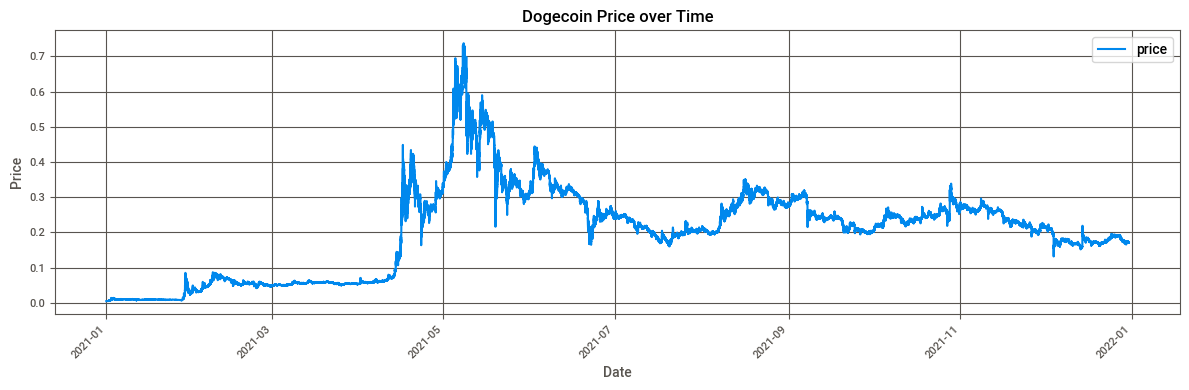

In [12]:
df['open_time'] = pd.to_datetime(df['open_time'])

df.plot(x='open_time', y='price',
        figsize=(12, 4),
        title="Dogecoin Price over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
#Jan to mid April 2021 Price remained very low
#Mid April to Mid May Major surge, peaking above $0.70 - the Elon effect? lets see!!!
#June to end of 2021 General decline and stabilization between

In [14]:
#Lets take the series from june since SARIMA is taking forever to train as i have a lot of values 


In [15]:
#lets select all entries after 2021-05-01
df = df.sort_values('open_time')
df = df[df['open_time'] >= '2021-05-01']
df = df.set_index('open_time').resample('H').mean()

n = len(df)
#80% train, 20% test
train_size = int(n * 0.8)
test_size  = n - train_size

train = df.iloc[:train_size]
test  = df.iloc[train_size:]

print(f"Train: {train.shape}, Test: {test.shape}")

Train: (4685, 1), Test: (1172, 1)


In [16]:
train.isna().sum()


price    6
dtype: int64

In [17]:
#using forward fill for now makes sense to fill null values
train = train.fillna(method='ffill')


In [18]:
train.isna().sum()


price    0
dtype: int64

In [19]:
#using forward fill for now makes sense to fill null values

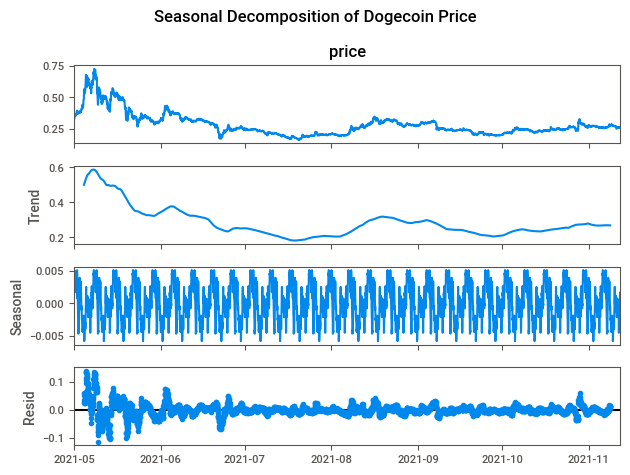

In [20]:
# Lets Check for weekly seasonality (7-day period)
result = seasonal_decompose(train['price'], model='additive', period=168)
result.plot()
plt.suptitle("Seasonal Decomposition of Dogecoin Price")
plt.tight_layout()
plt.show()


In [21]:
#Confirms repeating cycles every 168 hours - 7 days
#Resuduals Mostly centered around 0 except during the spike/ bull period

In [22]:
#ACF

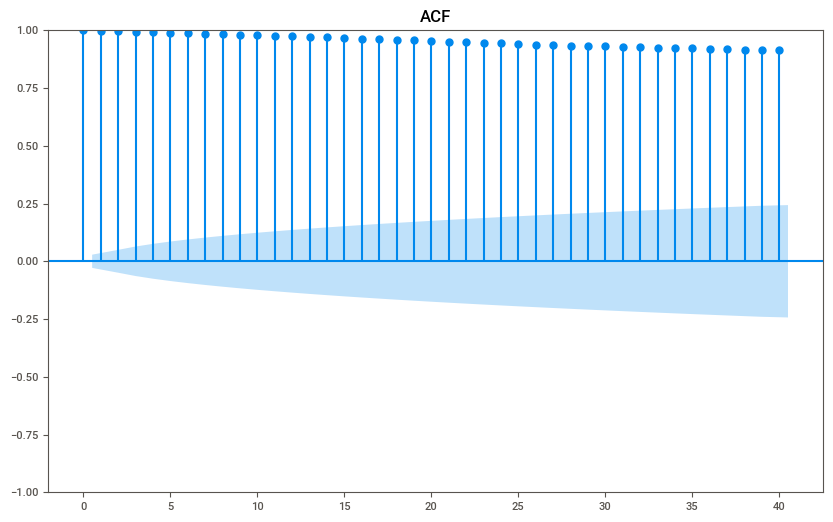

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(train['price'].dropna(),
          ax=ax,
          lags=40,
          alpha=0.05,
          title="ACF")
plt.show()


In [24]:
#PACF

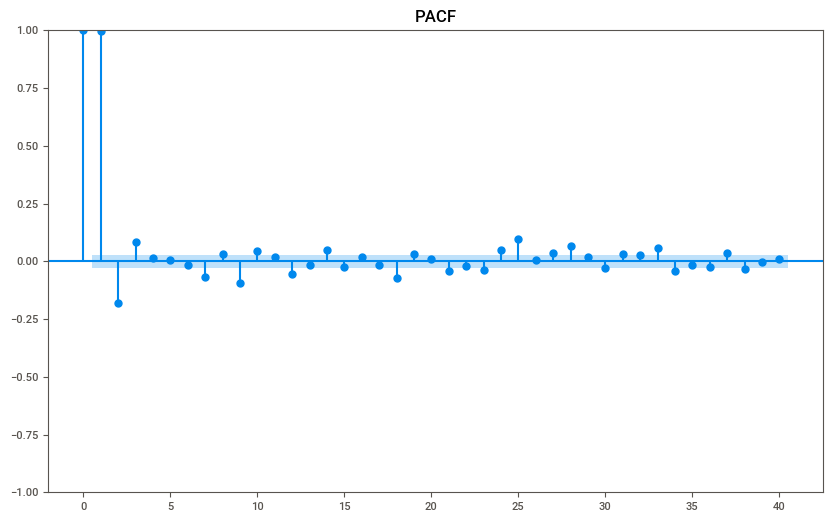

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(train['price'].dropna(),
          ax=ax,
          lags=40,
          alpha=0.05,
          title="PACF")
plt.show()


In [26]:
'''
We have very slow decay in ACF - alomost no decay - not stationary? 
High spike at lag 1,2,3 and some significant values scattered after. 
This Indicates possible AR,MA component, but unclear due to trend
''' 

'\nWe have very slow decay in ACF - alomost no decay - not stationary? \nHigh spike at lag 1,2,3 and some significant values scattered after. \nThis Indicates possible AR,MA component, but unclear due to trend\n'

In [27]:
#Lets confirm stationarity through ADF test

In [28]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(train['price'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


ADF Statistic: -1.9589261388292258
p-value: 0.3048676933720432


In [29]:
#Here we see p vlaue > 0.05. The data is not stationary. So lets difference and recheck 

In [30]:
train['price_diff'] = train['price'].diff().dropna()
#adf test
adf_result_diff = adfuller(train['price_diff'].dropna())
print(f"Differenced ADF Statistic: {adf_result_diff[0]}")
print(f"Differenced p-value: {adf_result_diff[1]}")


Differenced ADF Statistic: -13.791416590799022
Differenced p-value: 8.911709475979552e-26


In [31]:
#The differenced series is stationary as p < 0.05 -> d = 1
#Now lets check acf and pacf again 

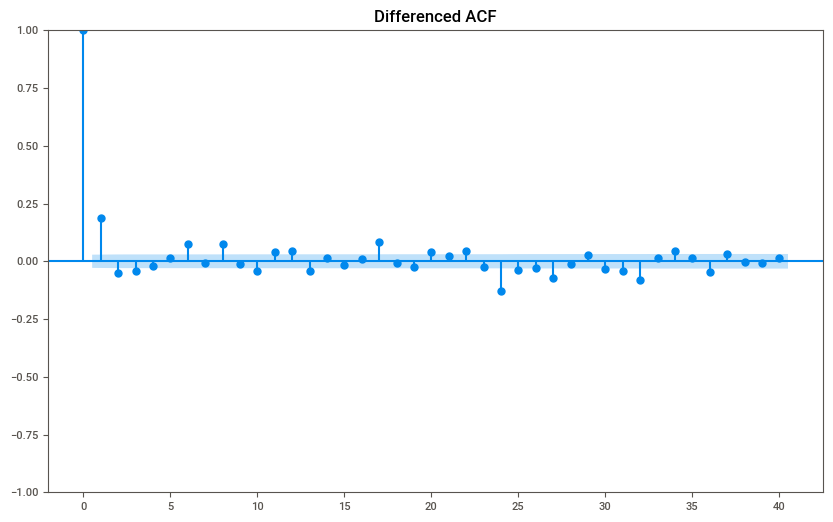

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(train['price_diff'].dropna(),
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Differenced ACF")
plt.show()


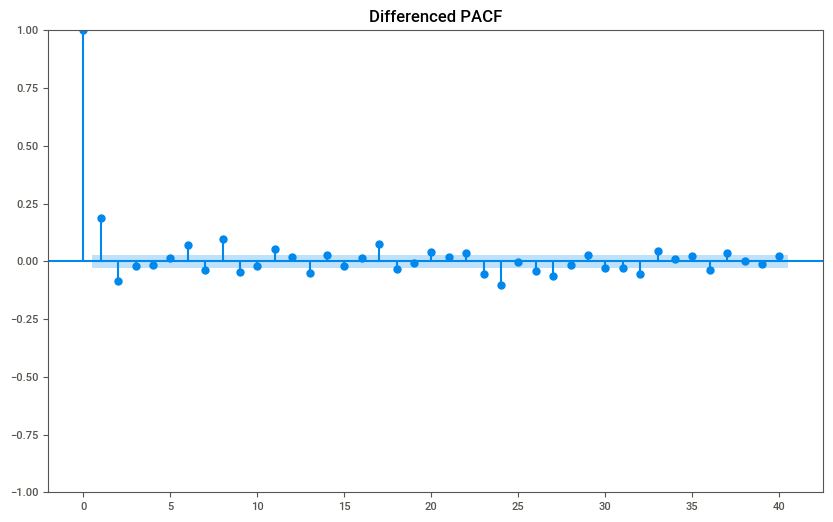

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(train['price_diff'].dropna(),
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Differenced PACF")
plt.show()


In [34]:
train = train.drop(columns = ['price_diff'])

In [35]:
#ACF - Lag 1,2,3 shows a significant spike, then everything quickly drops into the confidence band with some out here and there
#Same with pacf - lag 1,2 are out then drops again here and there there are spikes

# Models

In [36]:
#Lets check non seasonal models first and then move to seasonal - as this was my non seasonal dataset but we do see signs of seasonality

In [37]:
#ARIMA(3,1,2)


In [172]:
order = (3, 1, 2)
model = ARIMA(train['price'], order=order)
res   = model.fit()
print(res.summary())


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 4685
Model:                 ARIMA(3, 1, 2)   Log Likelihood               18075.880
Date:                Mon, 28 Apr 2025   AIC                         -36139.760
Time:                        13:04:23   BIC                         -36101.049
Sample:                    05-01-2021   HQIC                        -36126.147
                         - 11-12-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5311      1.011      0.525      0.599      -1.450       2.512
ar.L2         -0.2314      0.389     -0.595      0.552      -0.994       0.532
ar.L3          0.0258      0.123      0.209      0.8

In [39]:
#DIAGNOSTICS

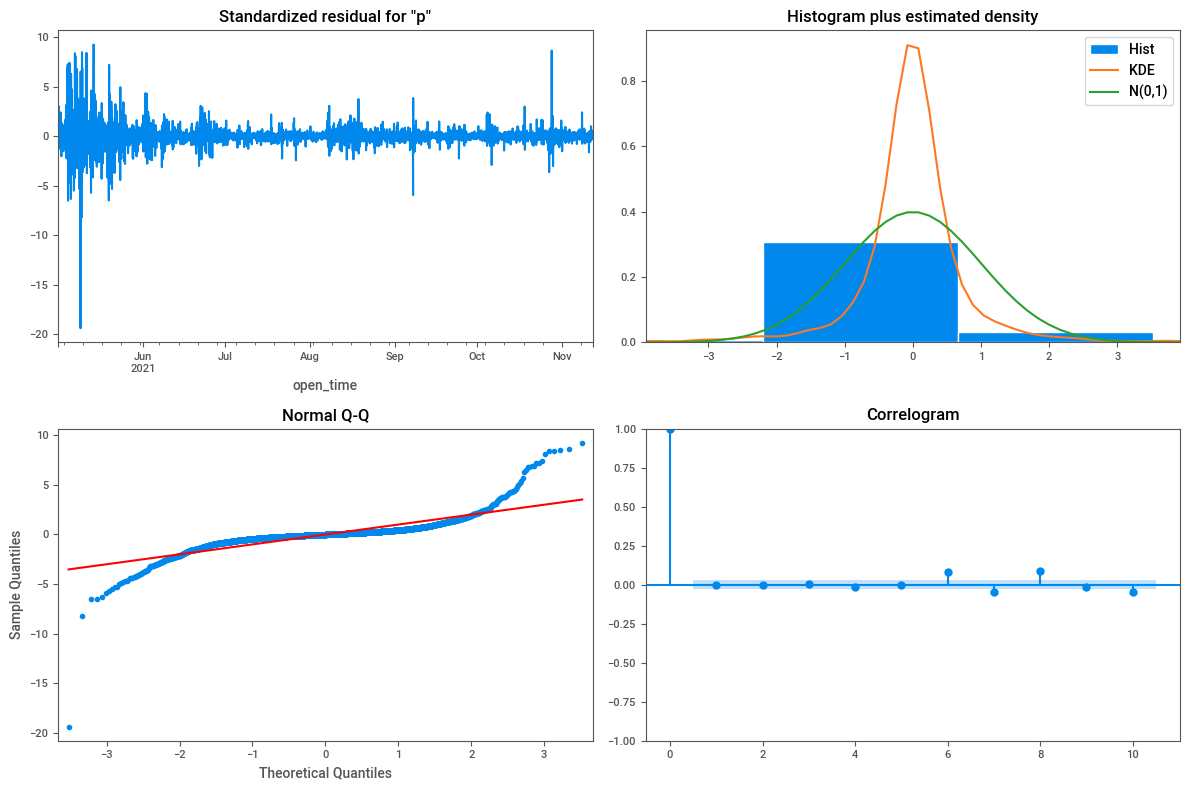

In [173]:
res.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [174]:
#forecast on test set
n_steps = len(test)
fc = res.forecast(steps=n_steps)
fc.index = test.index  

pred = res.get_prediction(start=test.index[0],
                          end=test.index[-1],
                          dynamic=False)

forecast_mean = pred.predicted_mean
forecast_ci   = pred.conf_int()

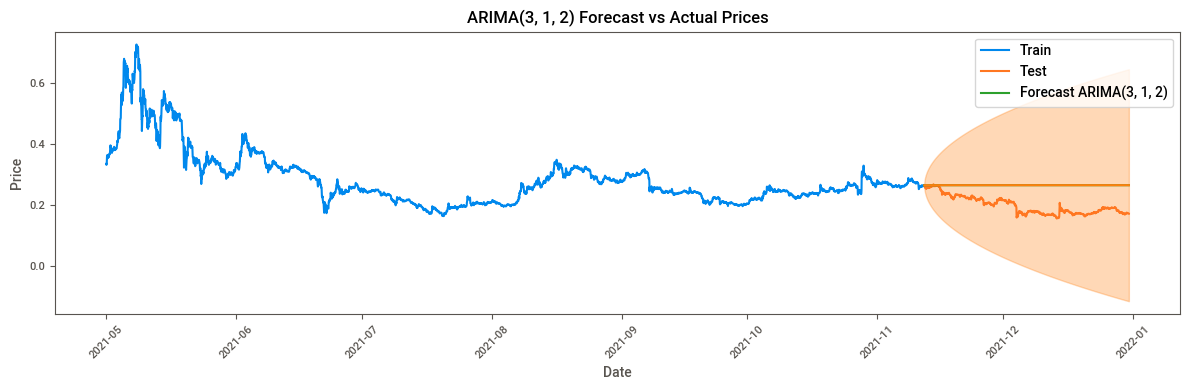

In [175]:
#plot
plt.figure(figsize=(12, 4))
plt.plot(train['price'],label='Train')    
plt.plot(test['price'],label='Test')    
plt.plot(fc,label=f'Forecast ARIMA{order}')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"ARIMA{order} Forecast vs Actual Prices")
plt.xticks(rotation=45)
plt.tight_layout()

plt.plot(forecast_mean.index,
         forecast_mean,
         label='Forecast',
         color='tab:orange')

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='tab:orange',
                 alpha=0.3,
                 label='95% CI')

plt.show()

In [179]:
#lets plot the p values for each lag and cross check 
lb = acorr_ljungbox(res.resid, lags=10, return_df=True)
p_values = lb['lb_pvalue'].to_frame().T
p_values.columns = [f'lag_{lag}' for lag in lb.index]
p_values

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
lb_pvalue,0.749884,0.901947,0.848675,0.737134,0.849785,0.091217,0.095701,0.011148,0.011585,0.012212


In [ ]:
#From lag 1 to lag 5 we are doing good but after that the p values < 0.05 so we are missing something there  -> maybe seasonal components 

In [43]:
# fail to capture the downward trend seen in the test set

In [44]:
'''
As we see in the Diagnostics plots and values we can say that 
Plot 1 - There is a lot of variablity
plot 2 - we can see the residuals are not normal
plot 3- again not normal 
plot 4 - few lags outside -> model fully doesnt capture all the trends 
'''

'\nAs we see in the Diagnostics plots and values we can say that \nPlot 1 - There is a lot of variablity\nplot 2 - we can see the residuals are not normal\nplot 3- again not normal \nplot 4 - few lags outside -> model fully doesnt capture all the trends \n'

In [45]:
#ARIMA(2,1,2)


In [180]:
order = (2, 1, 2)
model = ARIMA(train['price'], order=order)
res   = model.fit()
print(res.summary())


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 4685
Model:                 ARIMA(2, 1, 2)   Log Likelihood               18075.716
Date:                Mon, 28 Apr 2025   AIC                         -36141.433
Time:                        13:08:47   BIC                         -36109.173
Sample:                    05-01-2021   HQIC                        -36130.089
                         - 11-12-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3375      0.105      3.226      0.001       0.132       0.543
ar.L2         -0.1451      0.037     -3.937      0.000      -0.217      -0.073
ma.L1         -0.1383      0.105     -1.322      0.1

In [47]:
#DIAGNOSTICS

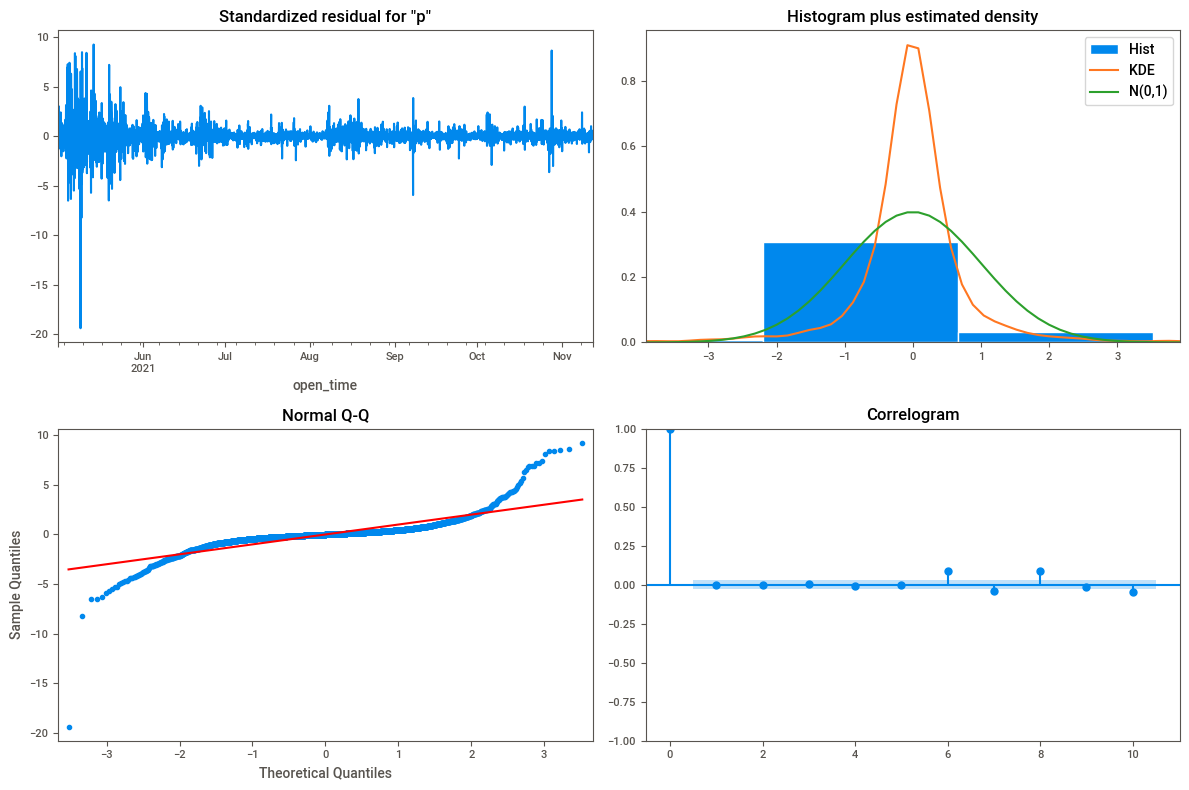

In [181]:
res.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [182]:
#forecast on test set
n_steps = len(test)
fc = res.forecast(steps=n_steps)
fc.index = test.index  

pred = res.get_prediction(start=test.index[0],
                          end=test.index[-1],
                          dynamic=False)

forecast_mean = pred.predicted_mean
forecast_ci   = pred.conf_int()

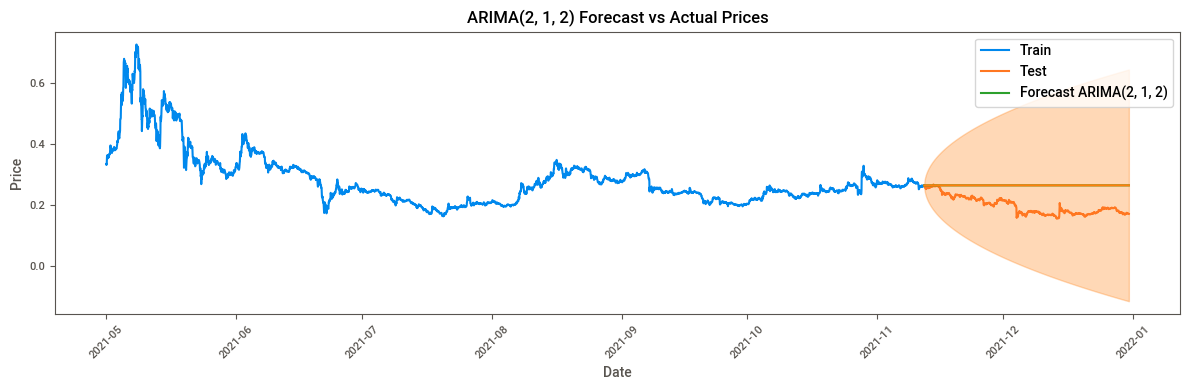

In [183]:
#plot
plt.figure(figsize=(12, 4))
plt.plot(train['price'],label='Train')    
plt.plot(test['price'],label='Test')    
plt.plot(fc,label=f'Forecast ARIMA{order}')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"ARIMA{order} Forecast vs Actual Prices")
plt.xticks(rotation=45)
plt.tight_layout()

plt.plot(forecast_mean.index,
         forecast_mean,
         label='Forecast',
         color='tab:orange')

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='tab:orange',
                 alpha=0.3,
                 label='95% CI')

plt.show()

In [184]:
#lets plot the p values for each lag and cross check 
lb = acorr_ljungbox(res.resid, lags=10, return_df=True)
p_values = lb['lb_pvalue'].to_frame().T
p_values.columns = [f'lag_{lag}' for lag in lb.index]
p_values

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
lb_pvalue,0.751521,0.901905,0.845691,0.72778,0.843089,0.085328,0.090128,0.010481,0.010921,0.011549


In [ ]:
#again from lag 1 to lag 5 we are doing good but after that the p values < 0.05 so we are missing something there  -> maybe seasonal components 

In [51]:
''' 
Lot of volatility in the residual plot
the histogram with KDE, Q-Q plot shows it may not be normal 
again there are a few spikes outside -> we need a better model 
'''

' \nLot of volatility in the residual plot\nthe histogram with KDE, Q-Q plot shows it may not be normal \nagain there are a few spikes outside -> we need a better model \n'

In [52]:
#The coefficients of MA order in both cases show up as insignificant -> lets try dropping them to MA(0) or MA(1) and check 

In [53]:
#ARIMA(2,1,1)


In [185]:
order = (2, 1, 1)
model = ARIMA(train['price'], order=order)
res   = model.fit()
print(res.summary())


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 4685
Model:                 ARIMA(2, 1, 1)   Log Likelihood               18075.774
Date:                Mon, 28 Apr 2025   AIC                         -36143.547
Time:                        13:09:40   BIC                         -36117.740
Sample:                    05-01-2021   HQIC                        -36134.472
                         - 11-12-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4137      0.063      6.568      0.000       0.290       0.537
ar.L2         -0.1262      0.012    -10.941      0.000      -0.149      -0.104
ma.L1         -0.2136      0.063     -3.408      0.0

In [55]:
#DIAGNOSTICS

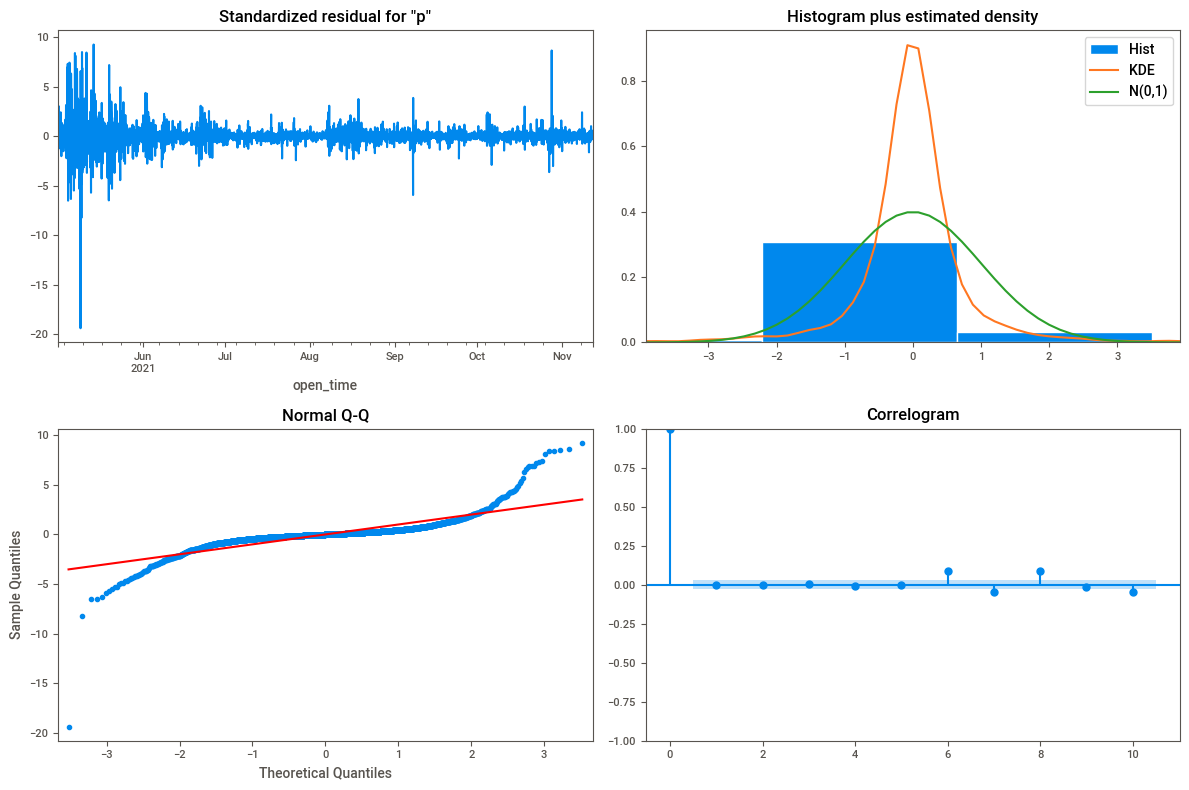

In [186]:
res.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [187]:
#forecast on test set
n_steps = len(test)
fc = res.forecast(steps=n_steps)
fc.index = test.index  

pred = res.get_prediction(start=test.index[0],
                          end=test.index[-1],
                          dynamic=False)

forecast_mean = pred.predicted_mean
forecast_ci   = pred.conf_int()

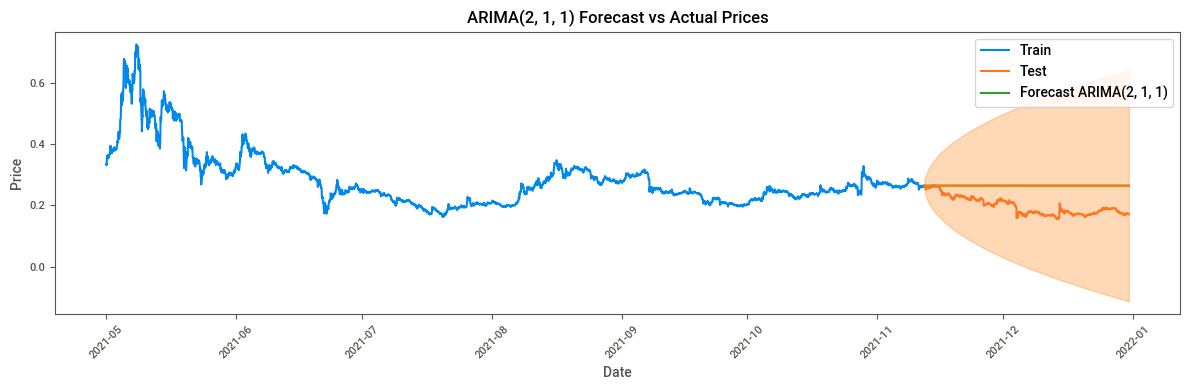

In [188]:
#plot
plt.figure(figsize=(12, 4))
plt.plot(train['price'],label='Train')    
plt.plot(test['price'],label='Test')    
plt.plot(fc,label=f'Forecast ARIMA{order}')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"ARIMA{order} Forecast vs Actual Prices")
plt.xticks(rotation=45)
plt.tight_layout()

plt.plot(forecast_mean.index,
         forecast_mean,
         label='Forecast',
         color='tab:orange')

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='tab:orange',
                 alpha=0.3,
                 label='95% CI')

plt.show()

In [189]:
#lets plot the p values for each lag and cross check 
lb = acorr_ljungbox(res.resid, lags=10, return_df=True)
p_values = lb['lb_pvalue'].to_frame().T
p_values.columns = [f'lag_{lag}' for lag in lb.index]
p_values

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
lb_pvalue,0.731511,0.891058,0.846082,0.660986,0.789611,0.072759,0.077618,0.008778,0.009147,0.009861


In [ ]:
#Same case again 

In [59]:
#Same but AIC is better , lets try MA(0)

In [60]:
#ARIMA(2,1,0)


In [190]:
order = (2, 1, 0)
model = ARIMA(train['price'], order=order)
res   = model.fit()
print(res.summary())


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 4685
Model:                 ARIMA(2, 1, 0)   Log Likelihood               18074.864
Date:                Mon, 28 Apr 2025   AIC                         -36143.728
Time:                        13:11:16   BIC                         -36124.373
Sample:                    05-01-2021   HQIC                        -36136.922
                         - 11-12-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2019      0.005     42.042      0.000       0.192       0.211
ar.L2         -0.0870      0.006    -13.888      0.000      -0.099      -0.075
sigma2      2.605e-05   1.15e-07    225.969      0.0

In [62]:
#DIAGNOSTICS

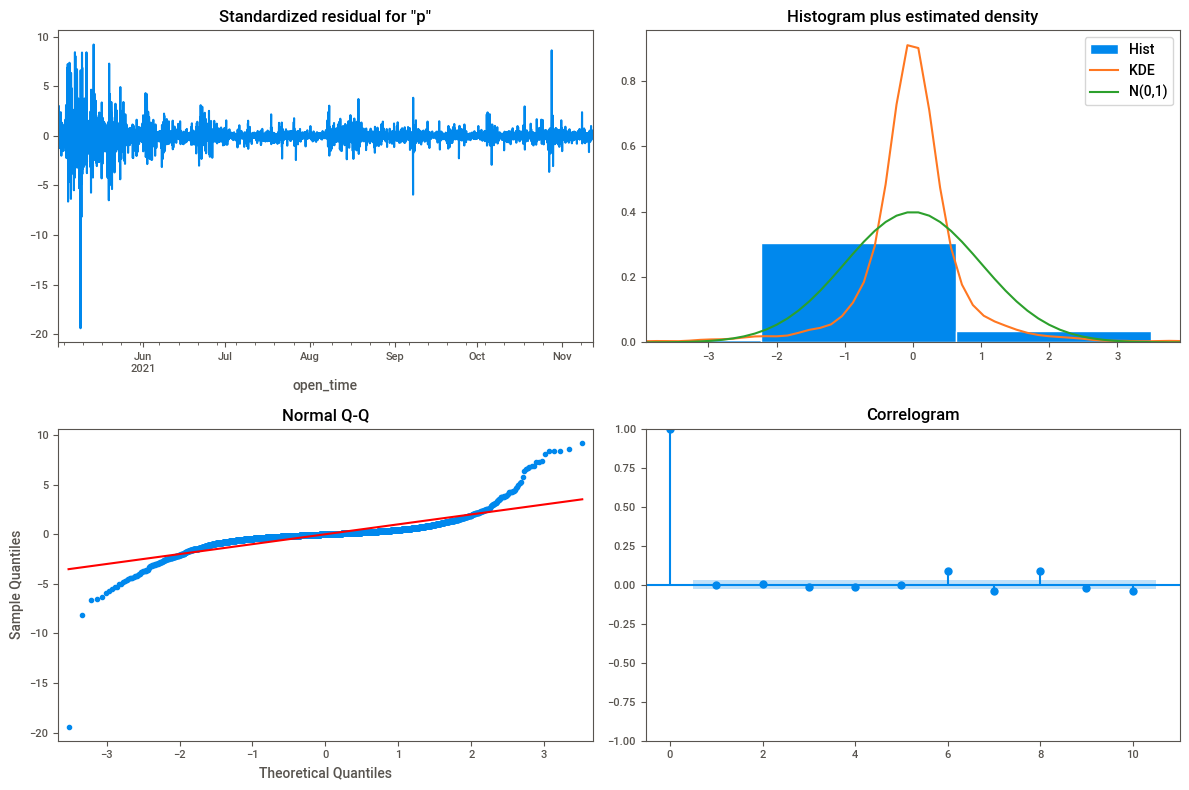

In [191]:
res.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [192]:
#forecast on test set
pred = res.get_prediction(start=test.index[0],
                          end=test.index[-1],
                          dynamic=False)

forecast_mean = pred.predicted_mean
forecast_ci   = pred.conf_int()

n_steps = len(test)
fc = res.forecast(steps=n_steps)
fc.index = test.index  

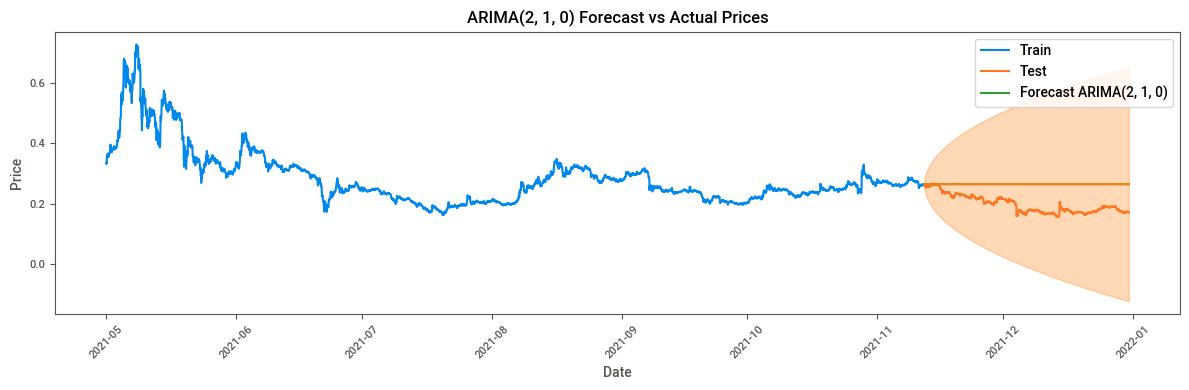

In [193]:
#plot
plt.figure(figsize=(12, 4))
plt.plot(train['price'],label='Train')    
plt.plot(test['price'],label='Test')    
plt.plot(fc,label=f'Forecast ARIMA{order}')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"ARIMA{order} Forecast vs Actual Prices")
plt.xticks(rotation=45)
plt.tight_layout()

plt.plot(forecast_mean.index,
         forecast_mean,
         label='Forecast',
         color='tab:orange')

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='tab:orange',
                 alpha=0.3,
                 label='95% CI')

plt.show()


In [194]:
#lets plot the p values for each lag and cross check 
lb = acorr_ljungbox(res.resid, lags=10, return_df=True)
p_values = lb['lb_pvalue'].to_frame().T
p_values.columns = [f'lag_{lag}' for lag in lb.index]
p_values

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
lb_pvalue,0.687719,0.840777,0.948473,0.845766,0.925166,0.095026,0.098834,0.012278,0.011913,0.013106


In [ ]:
#previously it was till lag 5 now its till 7 so this is better

In [66]:
#Again the ARIMA(2,1,0) performs the best 

In [67]:
#Lets try autoarima

In [68]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(train['price'], 
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        d=1,  #I did differenceing once
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=False)

print(auto_model.summary())


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35945.948, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-36130.978, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-36135.036, Time=1.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-36139.877, Time=1.54 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-36137.680, Time=2.10 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-36135.160, Time=2.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36108.184, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-36133.398, Time=1.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-36137.279, Time=1.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-36138.376, Time=1.30 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-36131.157, Time=5.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-36141.760, Time=1.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-36141.577, Time=1.82 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-36139.459, Time=1.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-36127

In [69]:
#This confirms that the best model is ARIMA(2,1,0) as we checked above 

In [70]:
#Lets check acf, pacf for this 

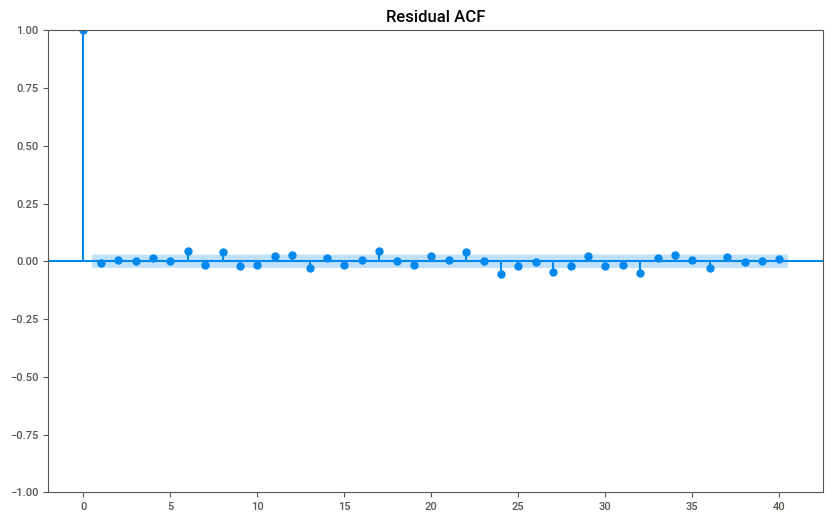

In [71]:
resid = res.resid.dropna()
#ACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(resid,
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Residual ACF")
plt.show()


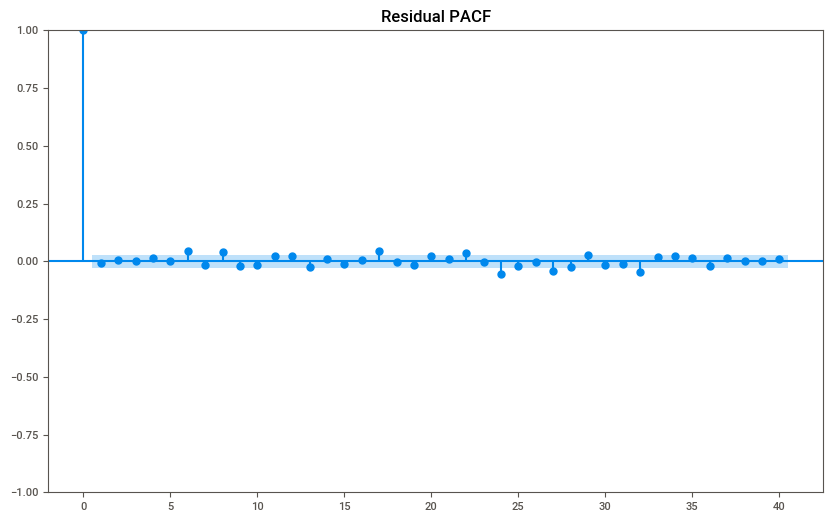

In [72]:
#PACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(resid,
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Residual PACF")
plt.show()


In [73]:
#Here we clearly see that there are some spikes outside the interval here and there

In [74]:
#Normality check using Shapiro Wilk test
from scipy.stats import shapiro
stat, p_value = shapiro(resid)
print(f"Shapiro–Wilk test: W = {stat:}, p‑value = {p_value:}")

Shapiro–Wilk test: W = 0.41216422386346285, p‑value = 4.386092294879108e-82


In [75]:
#The residuals are not normal at all as well observed in the diagonistic plots above

# Lets move to SARIMA models as there is a clear seasonal component. It might do well

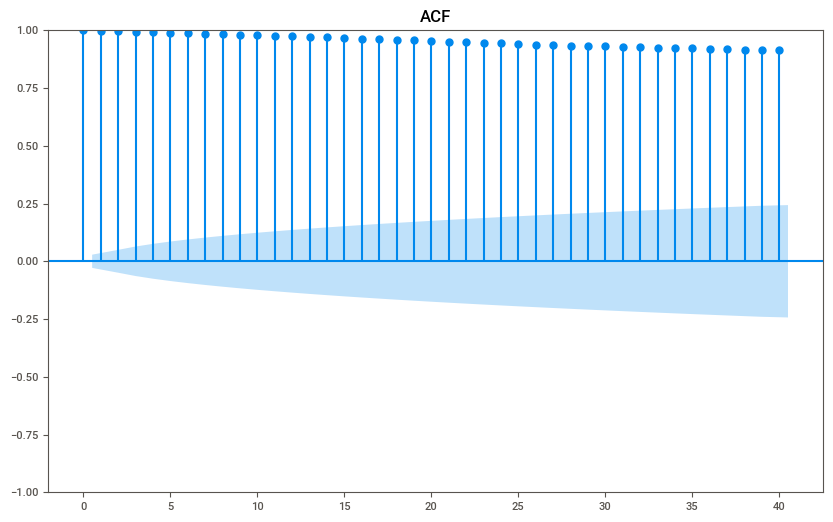

In [76]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(train['price'].dropna(),
          ax=ax,
          lags=40,
          alpha=0.05,
          title="ACF")
plt.show()


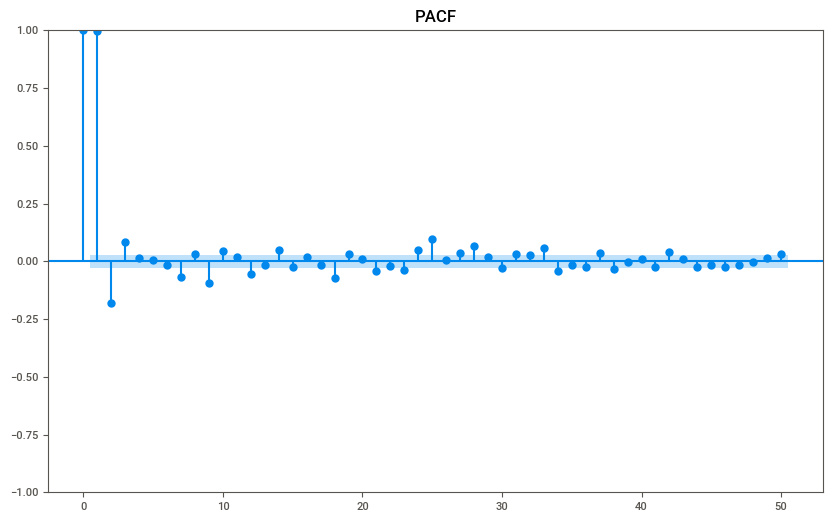

In [77]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(train['price'].dropna(),
          ax=ax,
          lags=50,
          alpha=0.05,
          title="PACF")
plt.show()


In [78]:
#WE earlier saw this plot , when we look at PACF properly there is a strong spike at lag 24

In [79]:
#Lets check on the non seasonal diffrenced series -> d = 1

In [80]:
from statsmodels.tsa.stattools import adfuller
train['price_diff'] = train['price'].diff().dropna()
#adf test
adf_result_diff = adfuller(train['price_diff'].dropna())
print(f"Differenced ADF Statistic: {adf_result_diff[0]}")
print(f"Differenced p-value: {adf_result_diff[1]}")


Differenced ADF Statistic: -13.791416590799022
Differenced p-value: 8.911709475979552e-26


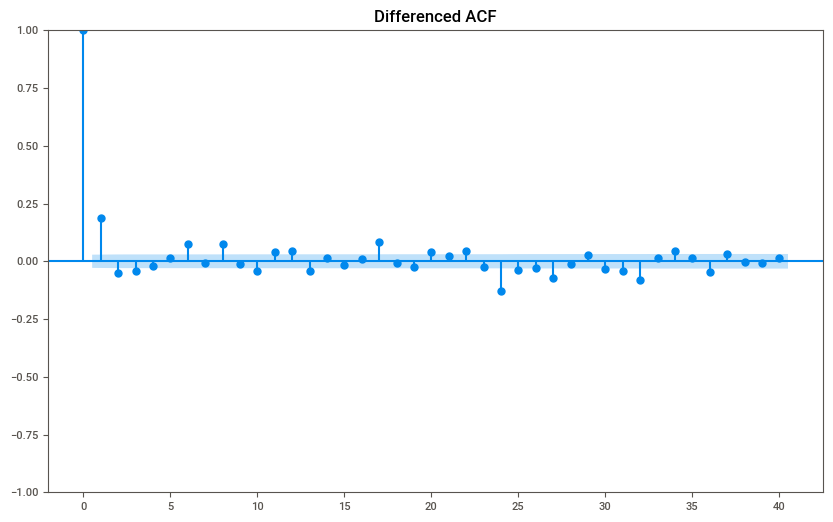

In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(train['price_diff'].dropna(),
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Differenced ACF")
plt.show()


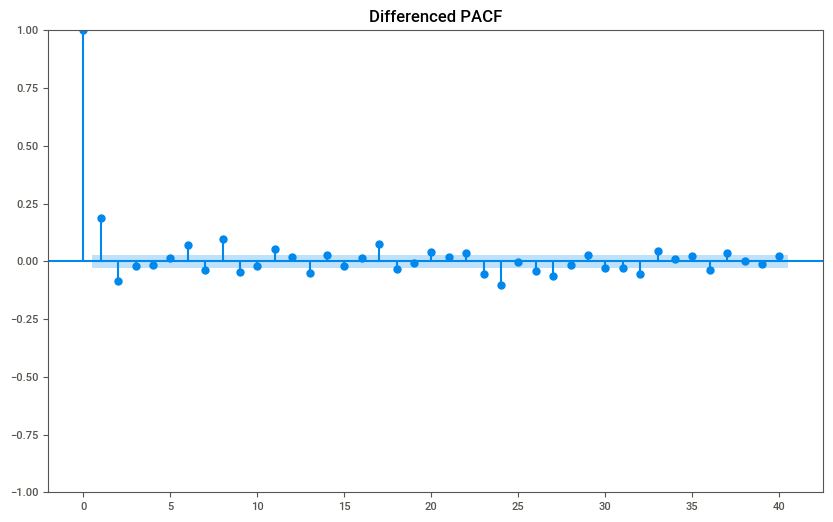

In [82]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(train['price_diff'].dropna(),
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Differenced PACF")
plt.show()


In [83]:
#The graph isnt that clear . So lets just plot the multiples of 24 and check if it is significant

<Figure size 600x300 with 0 Axes>

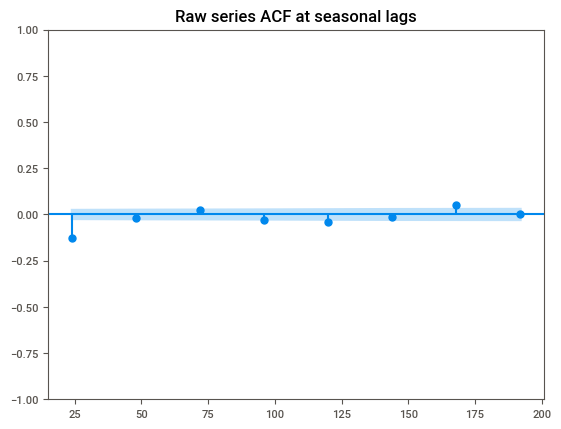

In [84]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plot_acf(train['price_diff'].dropna(), lags=[24, 48, 72, 96, 120, 144, 168, 192], alpha=0.05)
plt.title("Raw series ACF at seasonal lags")
plt.show()


<Figure size 600x300 with 0 Axes>

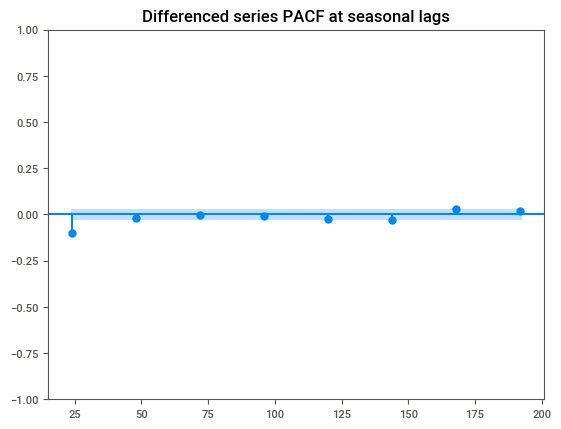

In [85]:
plt.figure(figsize=(6, 3))
plot_pacf(train['price_diff'].dropna(), lags=[24, 48, 72, 96, 120, 144, 168, 192], alpha=0.05)
plt.title("Differenced series PACF at seasonal lags")
plt.show()


In [86]:
#We can see that P = 1, Q = 1, no need of seasonal differencing as there is no slow decay 

In [87]:
#SARIMA(2,1,0)(1,0,1)

In [195]:
model = SARIMAX(train['price'],
                order=(2, 1, 0),
                seasonal_order=(1, 0, 1, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)

In [196]:
print(res.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                price   No. Observations:                 4685
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 24)   Log Likelihood               18011.129
Date:                              Mon, 28 Apr 2025   AIC                         -36012.258
Time:                                      13:12:41   BIC                         -35980.026
Sample:                                  05-01-2021   HQIC                        -36000.921
                                       - 11-12-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2019      0.005     42.502      0.000       0.193       0.211
ar.L2         -0.08

In [90]:
#DIAGNOSTICS

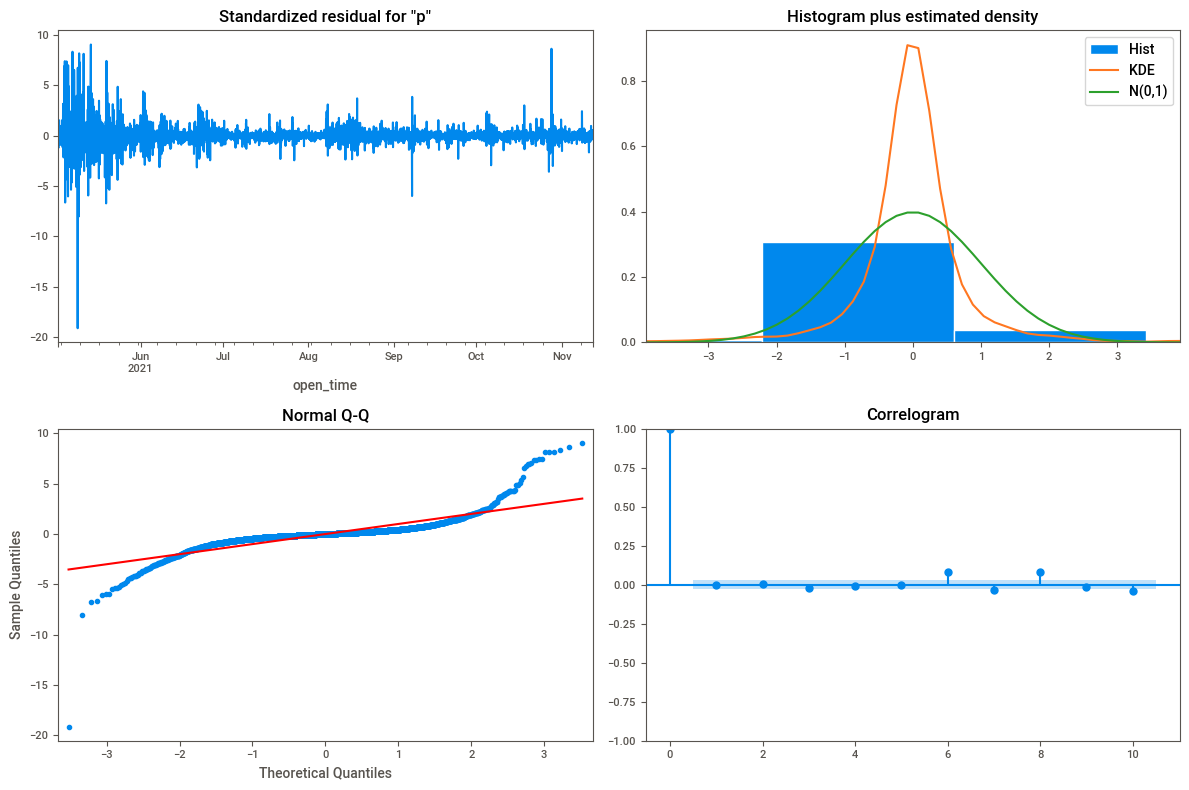

In [197]:
res.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [92]:
#Forecast

In [198]:
pred = res.get_prediction(start=test.index[0],
                          end=test.index[-1],
                          dynamic=False)

forecast_mean = pred.predicted_mean
forecast_ci   = pred.conf_int()

In [94]:
#Plot

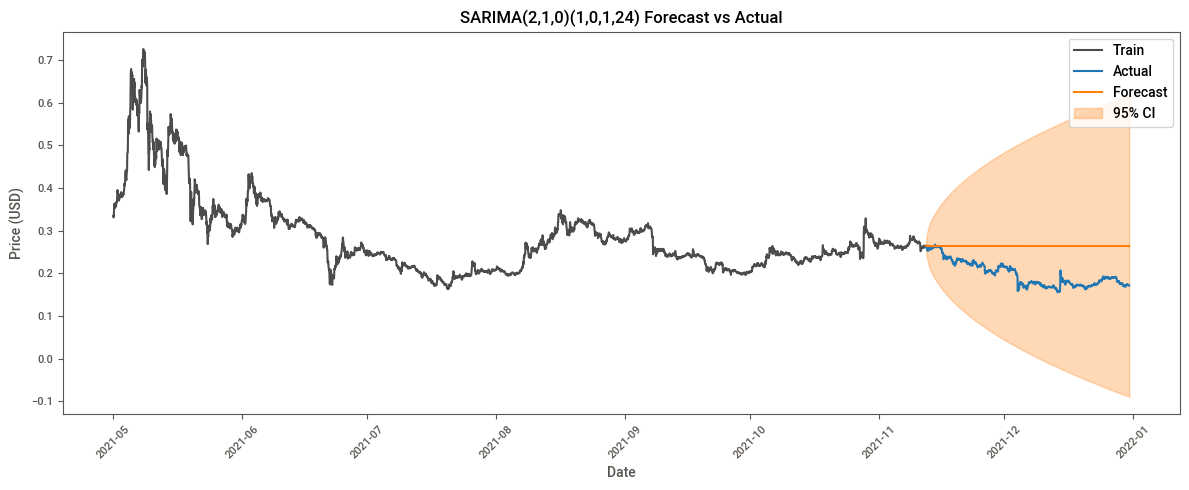

In [207]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['price'], label='Train',   color='black', alpha=0.7)
plt.plot(test.index,  test['price'],  label='Actual',  color='tab:blue')
plt.plot(forecast_mean.index,
         forecast_mean,
         label='Forecast',
         color='tab:orange')

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='tab:orange',
                 alpha=0.3,
                 label='95% CI')

plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("SARIMA(2,1,0)(1,0,1,24) Forecast vs Actual")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [200]:
#lets plot the p values for each lag and cross check 
lb = acorr_ljungbox(res.resid, lags=10, return_df=True)
p_values = lb['lb_pvalue'].to_frame().T
p_values.columns = [f'lag_{lag}' for lag in lb.index]
p_values

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
lb_pvalue,0.000037,0.00002,0.000071,0.00013,0.000347,0.000021,0.000038,0.000006,0.000007,0.000012


In [ ]:
#All the p values < 0.05 -> Big red flag - this performs worse than ARIMA (2,1,0)

In [96]:
'''
all the seasonal and non seasonal parameters chosen are significant 
The residuals are clearly not normal 
lag 4 , 9 still falls outside the interval 
'''

'\nall the seasonal and non seasonal parameters chosen are significant \nThe residuals are clearly not normal \nlag 4 , 9 still falls outside the interval \n'

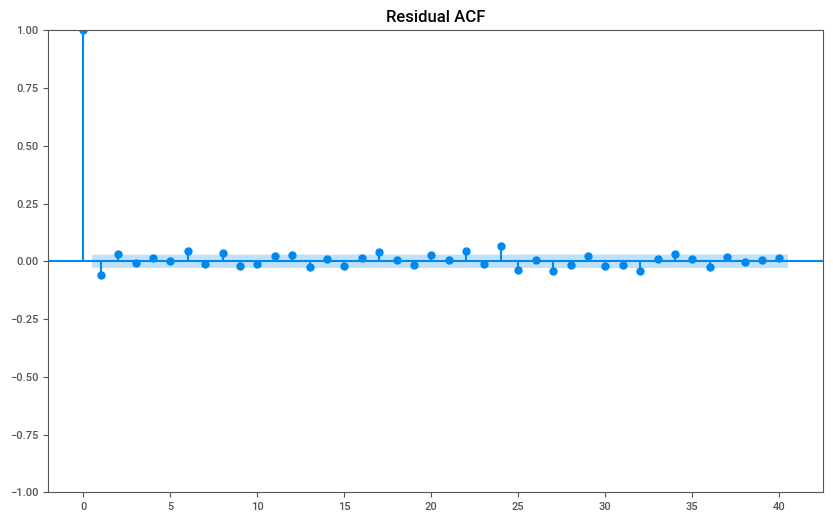

In [97]:
resid = res.resid.dropna()
#ACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(resid,
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Residual ACF")
plt.show()


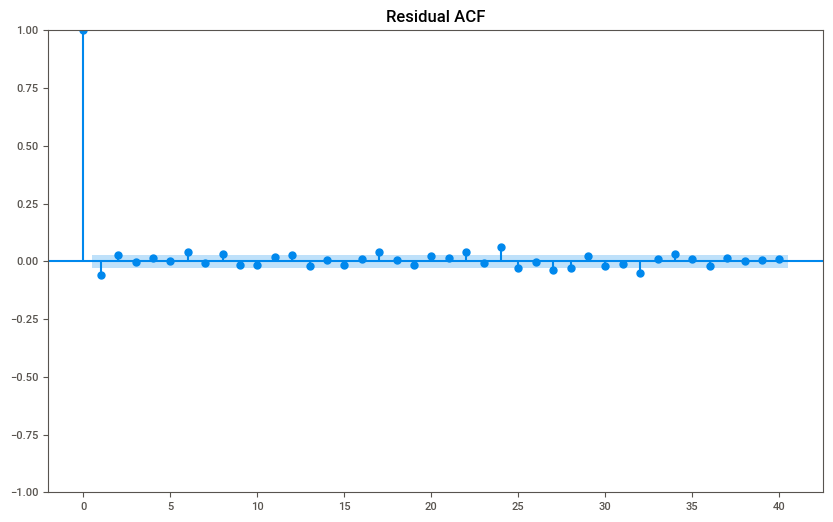

In [98]:
#PACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(resid,
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Residual ACF")
plt.show()


In [99]:
#SARIMA(2,1,0)(2,0,2)

In [201]:
model = SARIMAX(train['price'],
                order=(2, 1, 0),
                seasonal_order=(2, 0, 2, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())


                                        SARIMAX Results                                        
Dep. Variable:                                   price   No. Observations:                 4685
Model:             SARIMAX(2, 1, 0)x(2, 0, [1, 2], 24)   Log Likelihood               17922.322
Date:                                 Mon, 28 Apr 2025   AIC                         -35830.645
Time:                                         13:14:05   BIC                         -35785.557
Sample:                                     05-01-2021   HQIC                        -35814.781
                                          - 11-12-2021                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2019      0.005     41.890      0.000       0.192       0

In [101]:
#DIAGNOSTICS

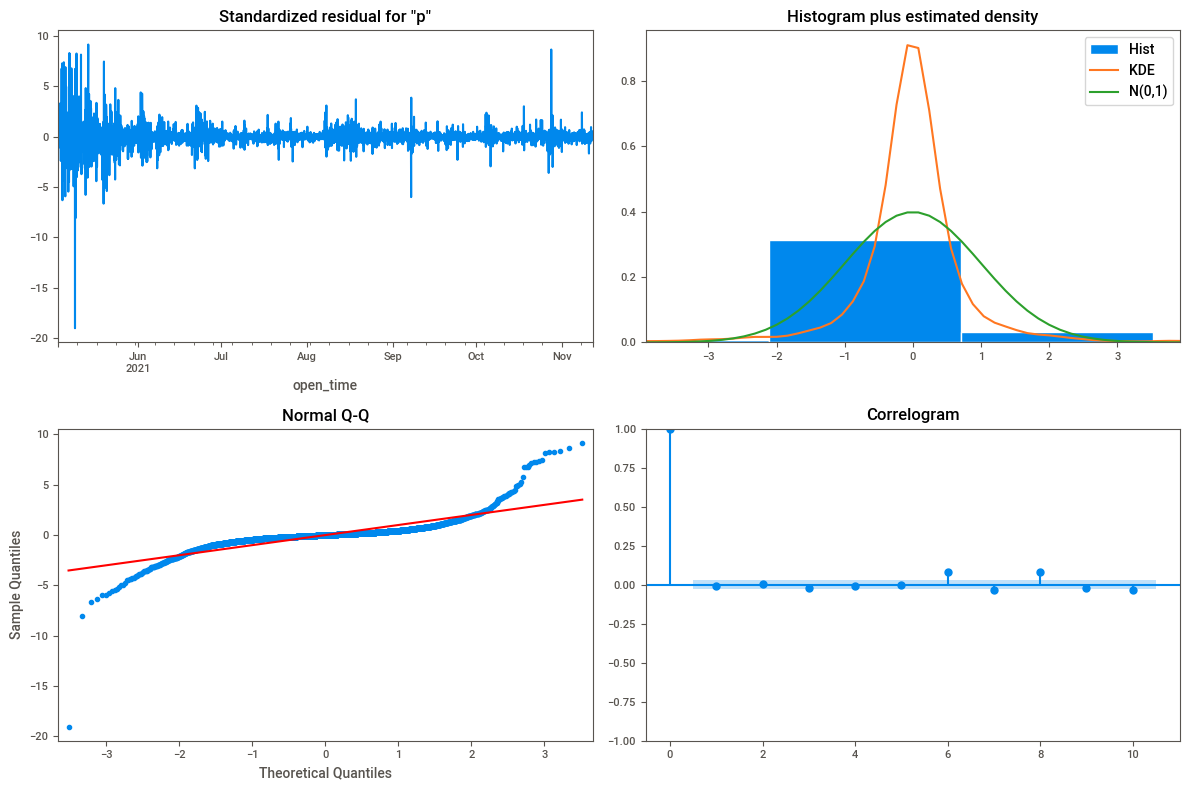

In [202]:
res.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [103]:
#Forecast

In [203]:
pred = res.get_prediction(start=test.index[0],
                          end=test.index[-1],
                          dynamic=False)

forecast_mean = pred.predicted_mean
forecast_ci   = pred.conf_int()

In [105]:
#Plot

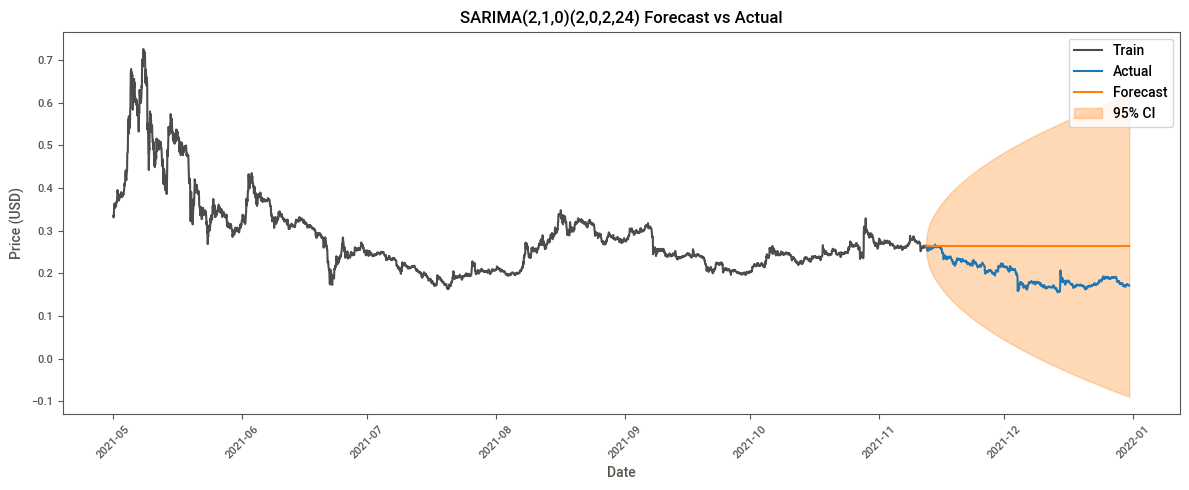

In [206]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['price'], label='Train',   color='black', alpha=0.7)
plt.plot(test.index,  test['price'],  label='Actual',  color='tab:blue')
plt.plot(forecast_mean.index,
         forecast_mean,
         label='Forecast',
         color='tab:orange')

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='tab:orange',
                 alpha=0.3,
                 label='95% CI')

plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("SARIMA(2,1,0)(2,0,2,24) Forecast vs Actual")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [208]:
#lets plot the p values for each lag and cross check 
lb = acorr_ljungbox(res.resid, lags=10, return_df=True)
p_values = lb['lb_pvalue'].to_frame().T
p_values.columns = [f'lag_{lag}' for lag in lb.index]
p_values

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
lb_pvalue,0.000011,0.000005,0.000018,0.000036,0.0001,0.000008,0.000015,0.000003,0.000003,0.000005


In [ ]:
#Same case here

In [107]:
'''
all the seasonal and non seasonal parameters chosen are significant 
The residuals are clearly not normal 
some lags fall outside the interval 
'''

'\nall the seasonal and non seasonal parameters chosen are significant \nThe residuals are clearly not normal \nsome lags fall outside the interval \n'

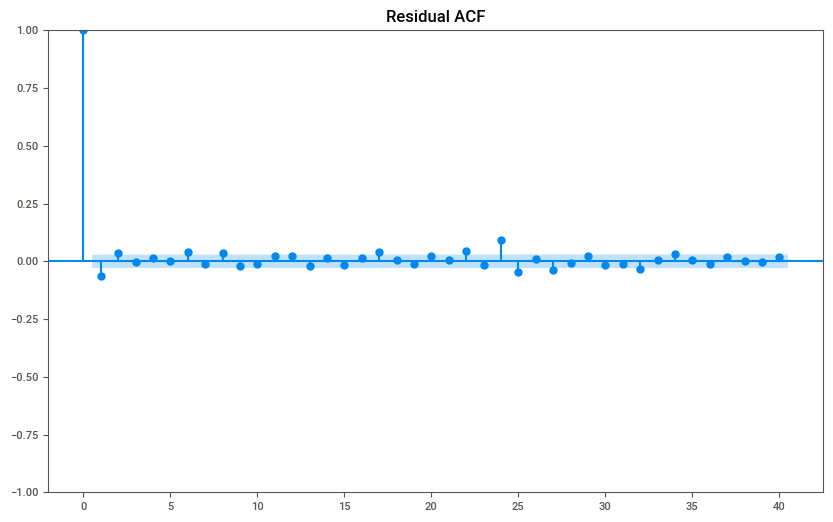

In [108]:
resid = res.resid.dropna()
#ACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(resid,
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Residual ACF")
plt.show()


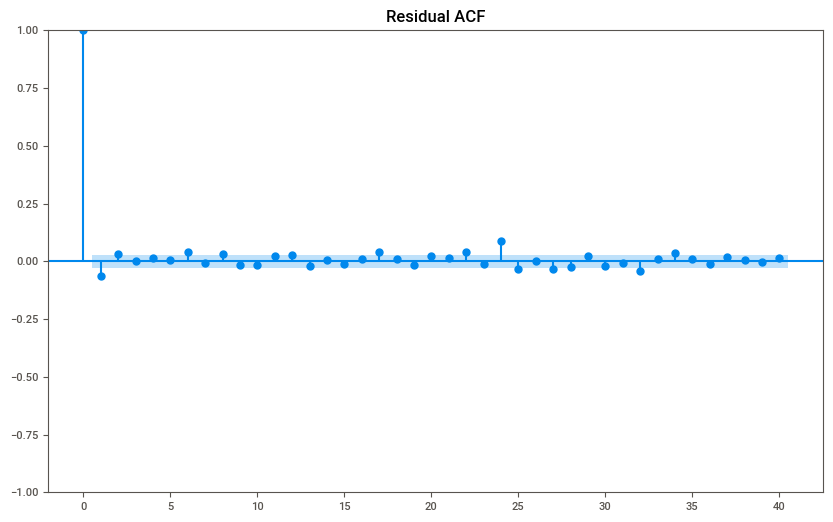

In [109]:
#PACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(resid,
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Residual ACF")
plt.show()


In [110]:
#SARIMA(2,1,0)(3,0,3)

In [209]:
model = SARIMAX(train['price'],
                order=(2, 1, 0),
                seasonal_order=(3, 0, 3, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())


                                         SARIMAX Results                                          
Dep. Variable:                                      price   No. Observations:                 4685
Model:             SARIMAX(2, 1, 0)x(3, 0, [1, 2, 3], 24)   Log Likelihood               17826.379
Date:                                    Mon, 28 Apr 2025   AIC                         -35634.759
Time:                                            13:17:23   BIC                         -35576.835
Sample:                                        05-01-2021   HQIC                        -35614.373
                                             - 11-12-2021                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2019      0.005     41.933      0

In [112]:
#DIAGNOSTICS

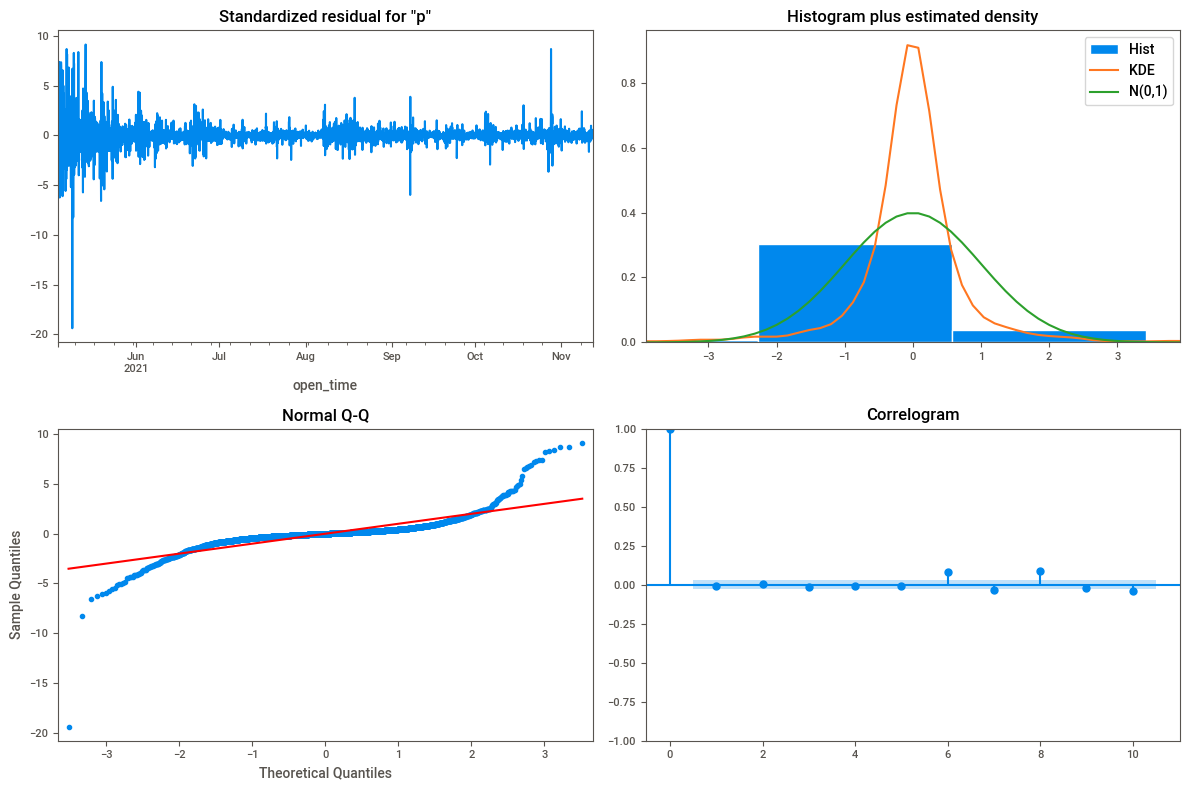

In [210]:
res.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [114]:
#Forecast

In [211]:
pred = res.get_prediction(start=test.index[0],
                          end=test.index[-1],
                          dynamic=False)

forecast_mean = pred.predicted_mean
forecast_ci   = pred.conf_int()

In [116]:
#Plot

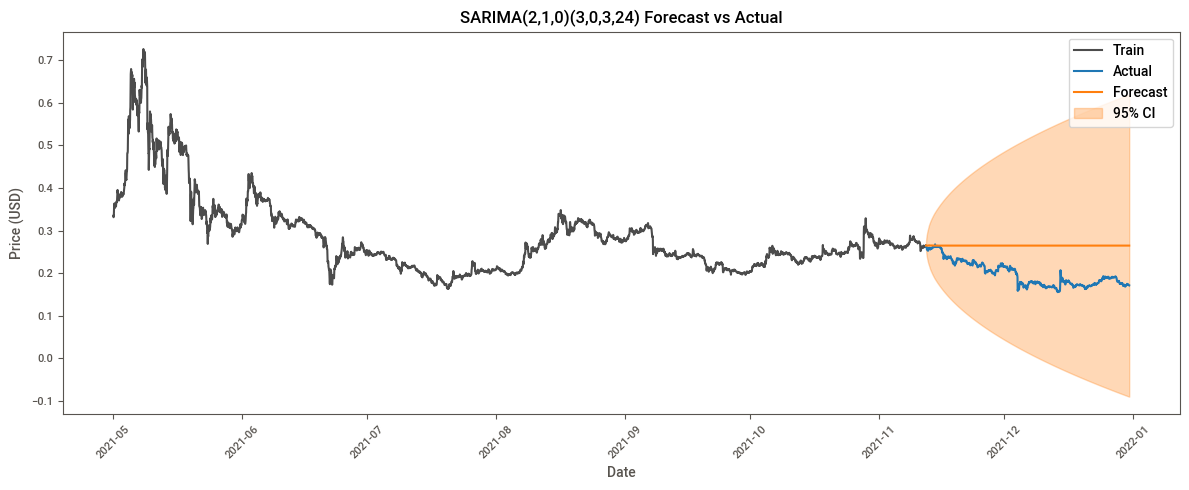

In [212]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['price'], label='Train',   color='black', alpha=0.7)
plt.plot(test.index,  test['price'],  label='Actual',  color='tab:blue')
plt.plot(forecast_mean.index,
         forecast_mean,
         label='Forecast',
         color='tab:orange')

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='tab:orange',
                 alpha=0.3,
                 label='95% CI')

plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("SARIMA(2,1,0)(3,0,3,24) Forecast vs Actual")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [213]:
#lets plot the p values for each lag and cross check 
lb = acorr_ljungbox(res.resid, lags=10, return_df=True)
p_values = lb['lb_pvalue'].to_frame().T
p_values.columns = [f'lag_{lag}' for lag in lb.index]
p_values

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
lb_pvalue,0.000025,0.000012,0.000046,0.000081,0.000221,0.000012,0.000021,0.000002,0.000002,0.000003


In [ ]:
#Performs worse

In [118]:
'''
P = 3, Q = 3 are not significant so lets drop them 
The residuals are clearly not normal 
some lags fall outside the interval 
'''

'\nP = 3, D = 3 are not significant so lets drop them \nThe residuals are clearly not normal \nsome lags fall outside the interval \n'

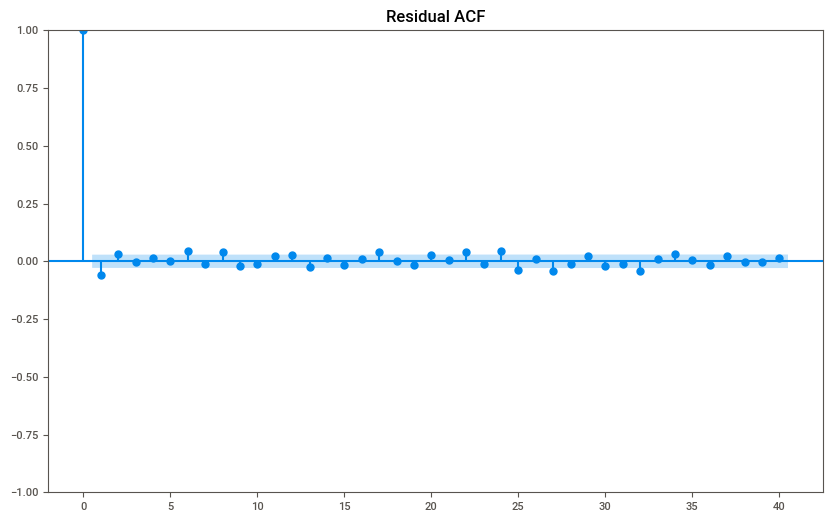

In [119]:
resid = res.resid.dropna()
#ACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(resid,
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Residual ACF")
plt.show()


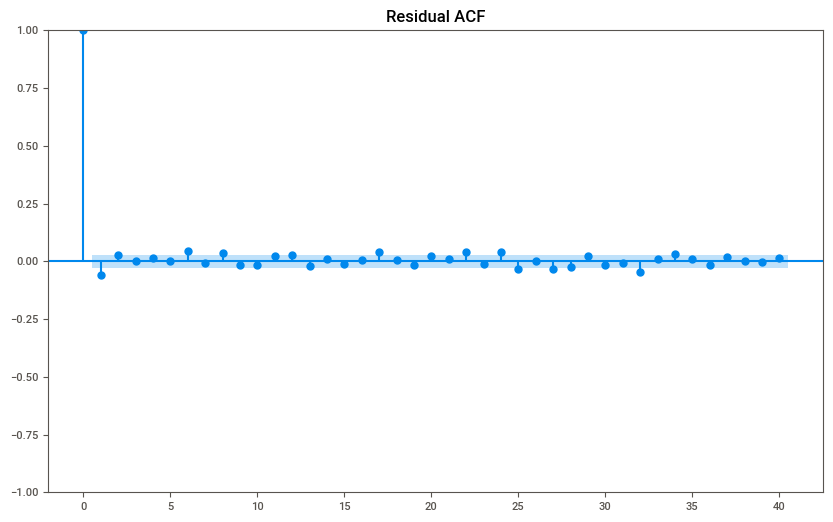

In [120]:
#PACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(resid,
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Residual ACF")
plt.show()


In [121]:
#Lets try auto SARIMA

In [122]:
#getting memory error - too many records - for large datasets with large seasonal values pm_auto_arima fails - common issue

In [123]:
'''import pmdarima as pm
auto_model = pm.auto_arima(
    train['price'],
    p = 2,
    q =0,
    d=1,                 
    start_P=0, max_P=5,
    start_Q=0, max_Q=5,
    start_D=0, max_D=1,
          
    m=24,                
    seasonal=True,
    stepwise=True,       
    trace=True,          
    error_action='ignore',
    suppress_warnings=True,
)

print(auto_model.summary())
'''

"import pmdarima as pm\nauto_model = pm.auto_arima(\n    train['price'],\n    p = 2,\n    q =0,\n    d=1,                 \n    start_P=0, max_P=5,\n    start_Q=0, max_Q=5,\n    start_D=0, max_D=1,\n          \n    m=24,                \n    seasonal=True,\n    stepwise=True,       \n    trace=True,          \n    error_action='ignore',\n    suppress_warnings=True,\n)\n\nprint(auto_model.summary())\n"

In [ ]:
#We can see so far having no seasonality performs much better - ARIMA(2,1,0) has the best score - AIC - -36141.8

In [124]:
#heteroskedasticity test
from statsmodels.stats.diagnostic import het_arch
lm_stat, lm_p, f_stat, f_p = het_arch(res.resid.dropna())
print("ARCH test p‑value:", lm_p)

ARCH test p‑value: 2.7763654752897535e-76


In [ ]:
#residuals exhibit heteroskedasticity i.e periods of high volatility followed by low volatility

In [ ]:
#now lets try GARCH 

In [319]:
from arch import arch_model
y_diff = train['price'].diff().dropna()
arma21 = ARIMA(y_diff, order=(3,0,3)).fit()
resids = arma21.resid

garch = arch_model(
    resids,
    mean='Zero',     
    vol='GARCH',
    p=1, q=1,
    dist='t'
)
garch_res = garch.fit(update_freq=5, disp='off')

C:\Users\AMIT\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [320]:
print(garch_res)

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                21162.7
Distribution:      Standardized Student's t   AIC:                          -42317.5
Method:                  Maximum Likelihood   BIC:                          -42291.7
                                              No. Observations:                 4684
Date:                      Mon, Apr 28 2025   Df Residuals:                     4684
Time:                              17:06:48   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

In [309]:
#Forecast
h = len(test)
fc = garch_res.forecast(horizon=h, reindex=False)
mu = np.zeros(h)  
var = fc.variance.values[-1]  

last_price= train['price'].iloc[-1]
diff_cumsum= np.cumsum(mu)  
var_cumsum= np.cumsum(var)
std_cumsum= np.sqrt(var_cumsum)
forecast_levels = last_price + diff_cumsum
lower = forecast_levels - 1.96 * std_cumsum
upper = forecast_levels + 1.96 * std_cumsum

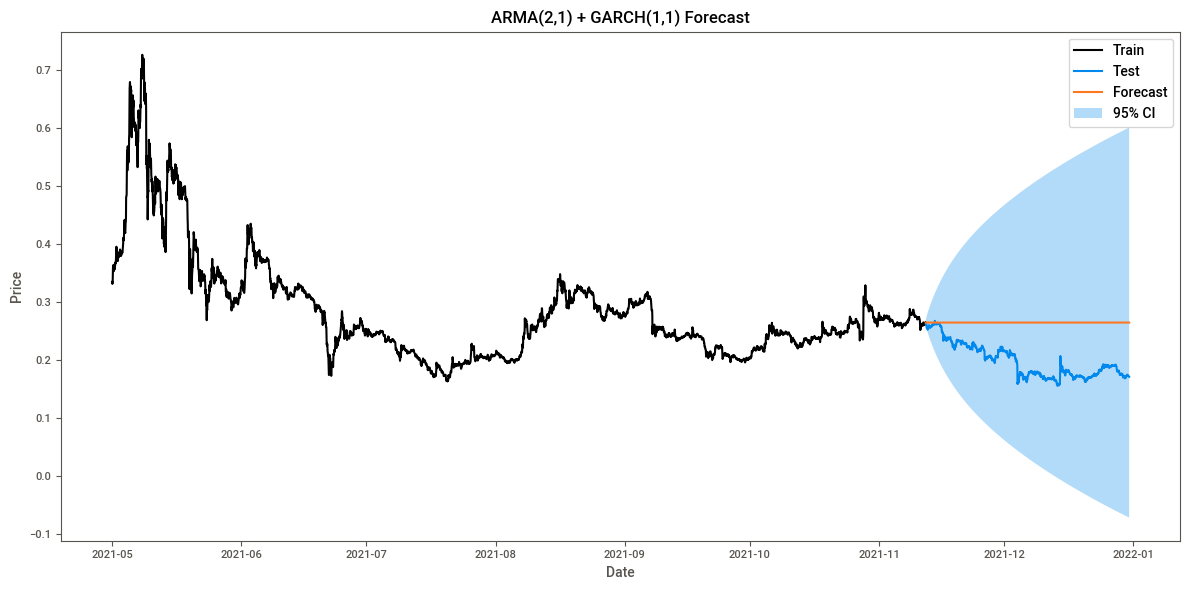

In [310]:
idx = test.index
plt.figure(figsize=(12,6))
plt.plot(train.index, train['price'],   'k',  label='Train')
plt.plot(idx,test['price'],  'C0', label='Test')
plt.plot(idx,forecast_levels,'C1', label='Forecast')
plt.fill_between(idx, lower, upper, alpha=0.3, label='95% CI')
plt.title('ARMA(2,1) + GARCH(1,1) Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#AIC already looks good. Way better than any other models

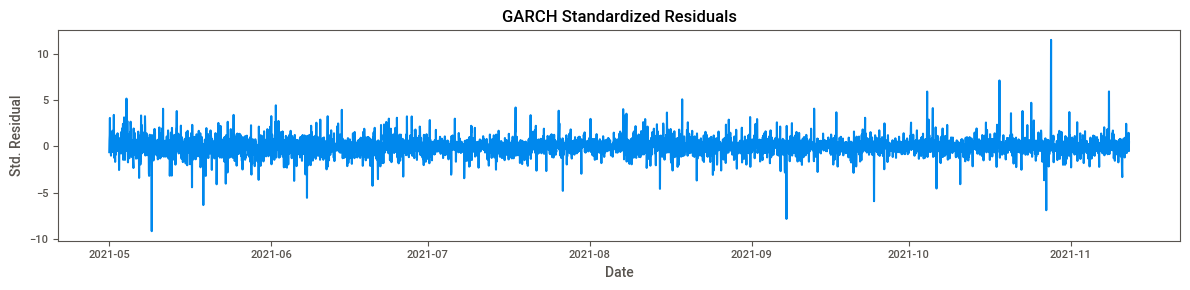

In [311]:
#DIAGNOSTICS
std_resid = res.std_resid
std_resid = std_resid.replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(12, 3))
plt.plot(std_resid.dropna())
plt.title("GARCH Standardized Residuals")
plt.xlabel("Date")
plt.ylabel("Std. Residual")
plt.tight_layout()
plt.show()

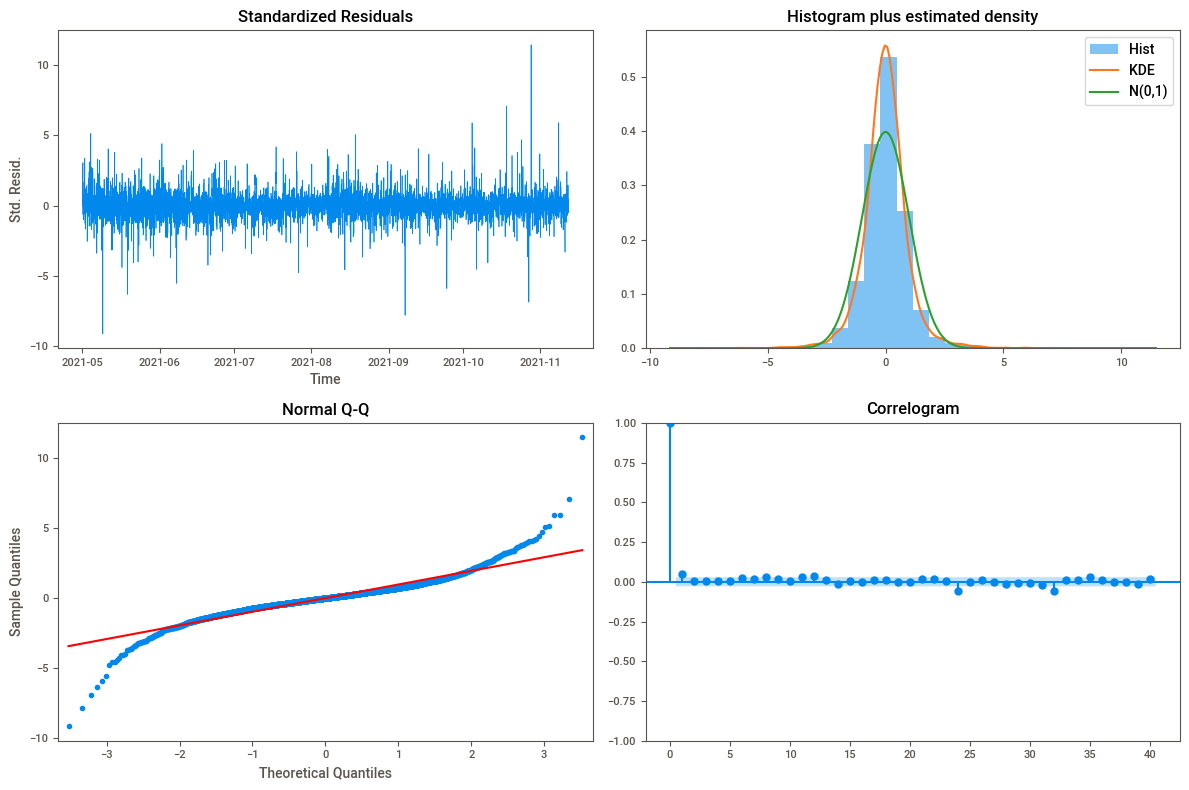

In [312]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
#residual time series
axes[0, 0].plot(std_resid, linewidth=0.5)
axes[0, 0].set_title('Standardized Residuals')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Std. Resid.')

#Histo + KDE
axes[0, 1].hist(std_resid, bins=30, density=True, alpha=0.5, label='Hist')
x = np.linspace(std_resid.min(), std_resid.max(), 200)
kde = stats.gaussian_kde(std_resid)
axes[0, 1].plot(x, kde(x), label='KDE')
axes[0, 1].plot(x, stats.norm.pdf(x, 0, 1), label='N(0,1)')
axes[0, 1].set_title('Histogram plus estimated density')
axes[0, 1].legend()

#Q-Q plot
qqplot(std_resid, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q')

#Correlogram
plot_acf(std_resid, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('Correlogram')

plt.tight_layout()
plt.show()

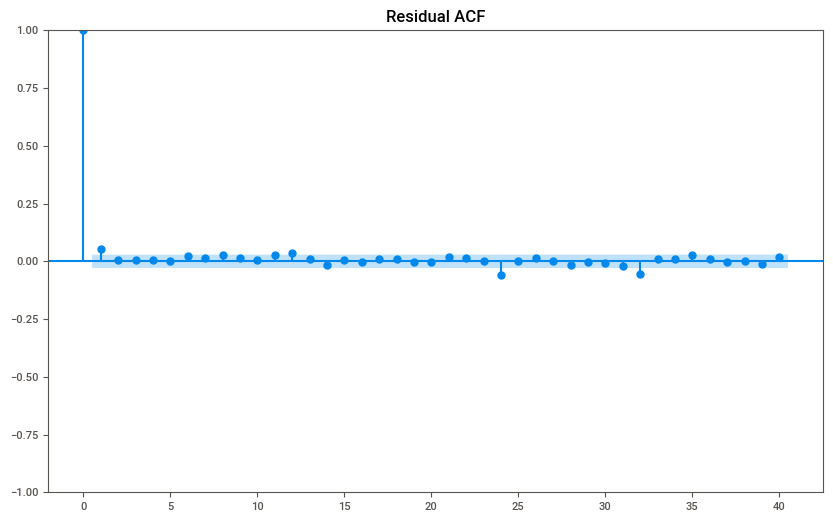

In [313]:
resid = res.resid.dropna()
#ACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(std_resid,
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Residual ACF")
plt.show()


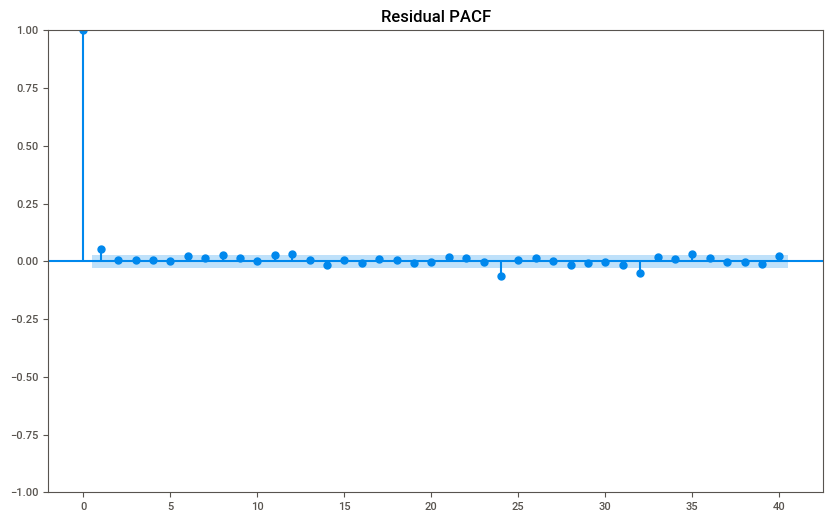

In [314]:
resid = res.resid.dropna()
#ACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(std_resid,
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Residual PACF")
plt.show()


In [ ]:
#Best AIC yet but there are lags outside the interval

In [297]:
from arch import arch_model
y_diff = train['price'].diff().dropna()
arma21 = ARIMA(y_diff, order=(2,0,1)).fit()
resids = arma21.resid

garch = arch_model(
    resids,
    mean='Zero',     
    vol='GARCH',
    p=1, q=1,
    dist='t'
)
garch_res = garch.fit(update_freq=5, disp='off')

C:\Users\AMIT\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [298]:
print(garch_res)

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                21161.5
Distribution:      Standardized Student's t   AIC:                          -42315.0
Method:                  Maximum Likelihood   BIC:                          -42289.2
                                              No. Observations:                 4684
Date:                      Mon, Apr 28 2025   Df Residuals:                     4684
Time:                              17:03:13   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

In [284]:
#Forecast
h= len(test)
fc= garch_res.forecast(horizon=h, reindex=False)
mu = np.zeros(h)  
var = fc.variance.values[-1]  

last_price= train['price'].iloc[-1]
diff_cumsum= np.cumsum(mu)  
var_cumsum= np.cumsum(var)
std_cumsum= np.sqrt(var_cumsum)
forecast_levels = last_price + diff_cumsum
lower = forecast_levels - 1.96 * std_cumsum
upper = forecast_levels + 1.96 * std_cumsum

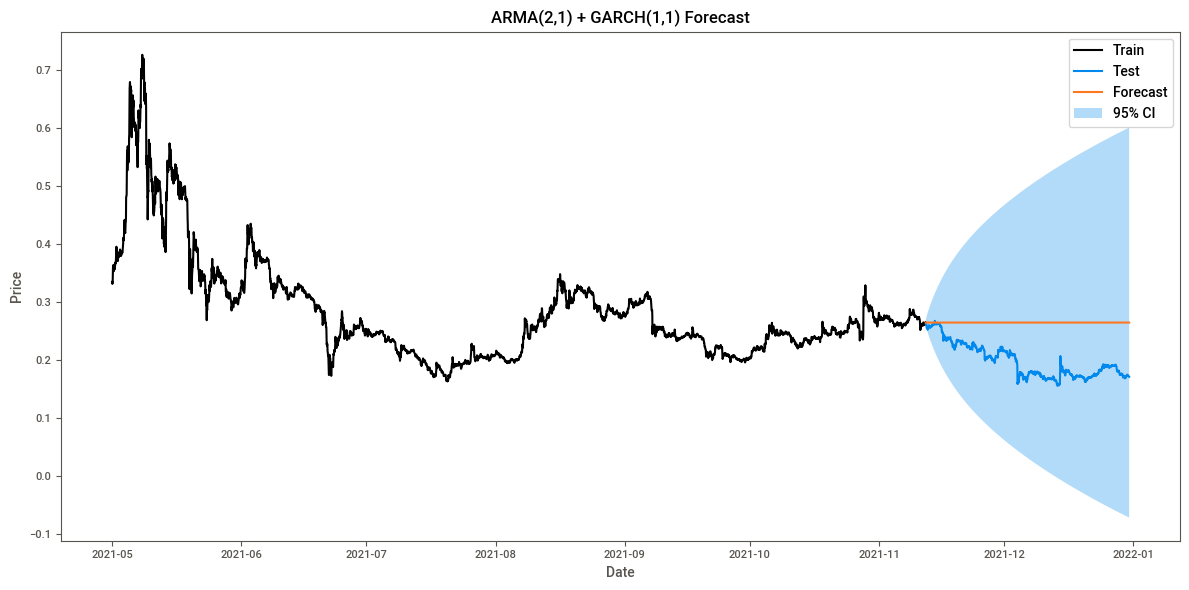

In [285]:
idx = test.index
plt.figure(figsize=(12,6))
plt.plot(train.index, train['price'],   'k',  label='Train')
plt.plot(idx,test['price'],  'C0', label='Test')
plt.plot(idx,forecast_levels,'C1', label='Forecast')
plt.fill_between(idx, lower, upper, alpha=0.3, label='95% CI')
plt.title('ARMA(2,1) + GARCH(1,1) Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#AIC already looks good. Way better than any other non GARCH models

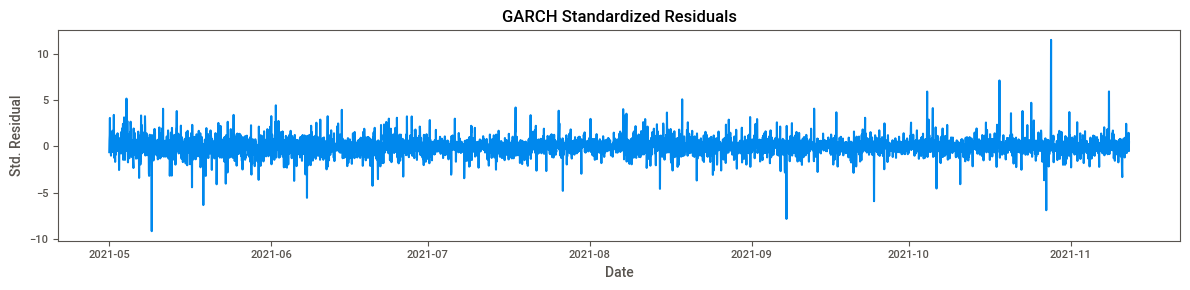

In [286]:
#DIAGNOSTICS
std_resid = res.std_resid
std_resid = std_resid.replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(12, 3))
plt.plot(std_resid.dropna())
plt.title("GARCH Standardized Residuals")
plt.xlabel("Date")
plt.ylabel("Std. Residual")
plt.tight_layout()
plt.show()

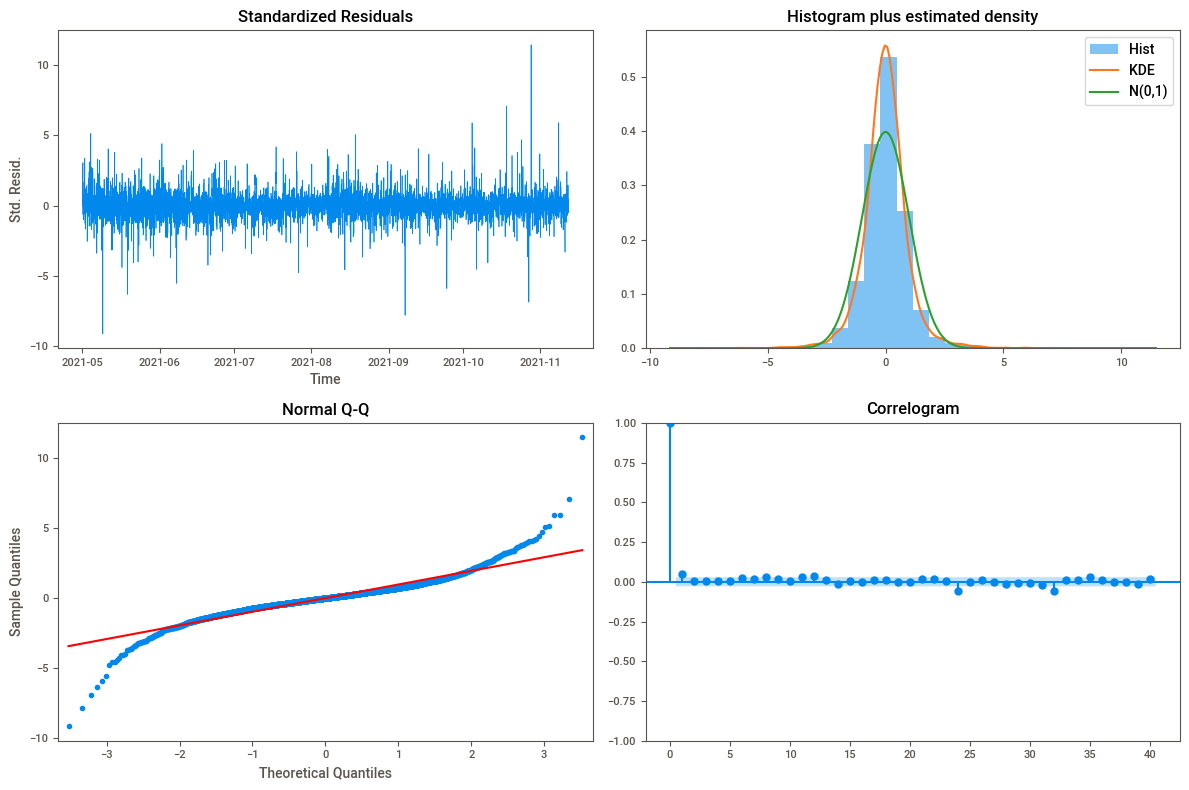

In [287]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
#residual time series
axes[0, 0].plot(std_resid, linewidth=0.5)
axes[0, 0].set_title('Standardized Residuals')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Std. Resid.')

#Histo + KDE
axes[0, 1].hist(std_resid, bins=30, density=True, alpha=0.5, label='Hist')
x = np.linspace(std_resid.min(), std_resid.max(), 200)
kde = stats.gaussian_kde(std_resid)
axes[0, 1].plot(x, kde(x), label='KDE')
axes[0, 1].plot(x, stats.norm.pdf(x, 0, 1), label='N(0,1)')
axes[0, 1].set_title('Histogram plus estimated density')
axes[0, 1].legend()

#Q-Q plot
qqplot(std_resid, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q')

#Correlogram
plot_acf(std_resid, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('Correlogram')

plt.tight_layout()
plt.show()

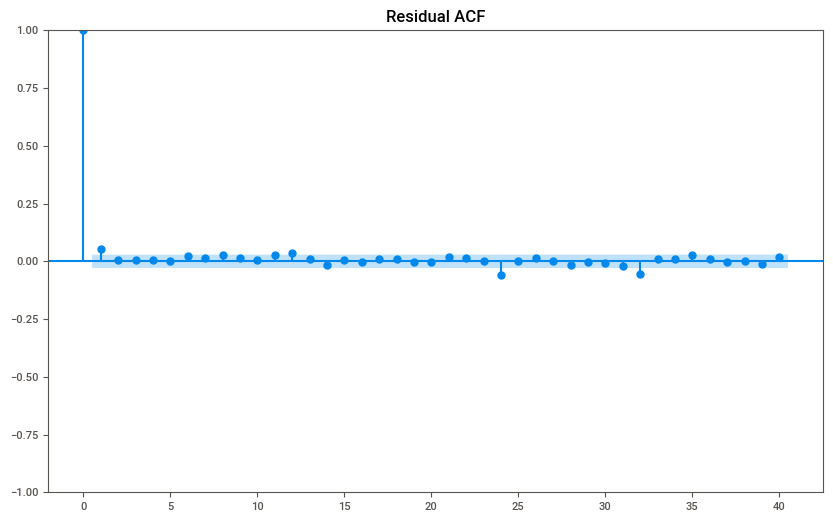

In [288]:
resid = res.resid.dropna()
#ACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(std_resid,
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Residual ACF")
plt.show()


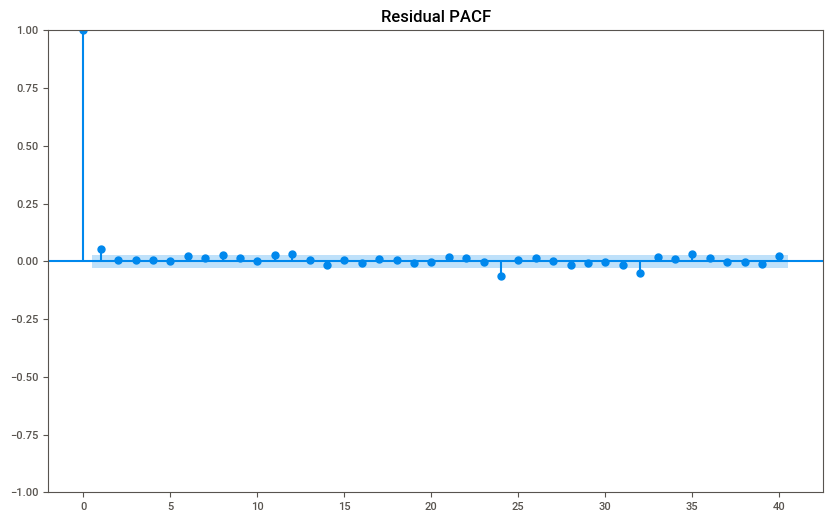

In [289]:
resid = res.resid.dropna()
#PACF
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(std_resid,
          ax=ax,
          lags=40,
          alpha=0.05,
          title="Residual PACF")
plt.show()


In [290]:
#lets plot the p values for each lag and cross check 
lb = acorr_ljungbox(std_resid, lags=10, return_df=True)
p_values = lb['lb_pvalue'].to_frame().T
p_values.columns = [f'lag_{lag}' for lag in lb.index]
p_values



,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
lb_pvalue,0.000446,0.00189,0.005347,0.011863,0.024084,0.016915,0.021015,0.010227,0.011719,0.018937


In [ ]:
#even though the AIC score is way better we can see here that there is a significant correlation left out 

In [ ]:
#Still not the best but out of all the models we have tried the ARMA(2,1,1) GARCH (1,1) worked the best